# Synopsis

#### Update 4: I replaced edu-vmec with the VMEC output in DESC/examples. Should be finished now.
* Compared to more equilibrium and the mercier quantities matched except for the few outlier points near rho=0 and rho=1. Can also use `compute_plots(use_quad_grid=True)` in cell 8 to get closer matches.

#### Update 3: I think this implementation is correct. Can't find anything that would be wrong.
* New grid update somewhat fixes the symmetry bug I mentioned in June. But turning it off gives better matches to STELLOPT.
* Heliotron and dshape are near-exact matches to STELLOPT with symmetry off, close with symmetry on.
* All implementations of the Magnetic Well parameter between DESC and STELLOPT agree on crossing.
* Increasing the number of surfaces (rho resolution) on educational VMEC input from 256 to 1024 didn't change anything significantly. Educational VMEC's heliotron plot's crossing did shift left toward the point where the STELLOPT data and DESC magnetic wells cross.
* I had mentioned at the meeting that the DESC plots don't match educational vmec's plots. I don't think that means much anymore. Previously all the curves (desc, stellopt, edu-vmec) disagreed, causing me confusion. I couldn't single out one of them as correct or incorrect. Now that STELLOPT and DESC agree, I think we can claim educational-vmec is doing something wrong.
* I think what took me longer than I thought with this was:
    - I was learning basics of DESC code as it was my first project in DESC.
    - The STELLOPT code really looks like they implement the magnetic well parameter from Landreman equation 3.2. So when my implementation didn't match that, I was scratching my head wondering why. Based on these results it looks like STELLOPT secretly implements equation 4.19.
    - Didn't know edu-vmec was giving bad results (I wonder if this is also true for rotational transform stuff).
    - I had to account for sym / NFP / single surface bugs in the grid class to fix d$\theta$ * d$\zeta$ stuff.

#### Update 2: works with arbitrary grids and computes magnetic well parameter over multiple flux surfaces simultaneously
Made use of the `surface_integrals` functionality I added while coding the new rotational transform function. The objective will still function in the same way as before if a single rho surface is given as input. However, computing magnetic well over multiple flux surfaces at once offers at least two benefits. It
* Simplifies end user code. They don't have to create routines and loop through things.
* Increases performance. I used to wait for this jupyter notebook to run for 30 minutes to get values to plot. Now it runs in 1 minute.
* Please see [a bug in the grid class](#Surface-element-computation-problem-and-solution). The solution to this bug for grids with a single rho surface is simple. If the functions I added to `compute.utils` are used then the developer/user doesn't have to worry about it. However, for multiple rho surface grids, the fix isn't as simple. Until that fix is implemented, if the user wants magnetic well computed on a grid with multiple values of rho, for best accuracy they need to set NFP=1 in the grid provided to magnetic well.

#### Update 1: alternative version of magnetic well in Landreman paper added.
It seems to have more responsive curves, and it has the same abrupt change as STELLOPT for HELIOTRON. It yields a perfect match for Heliotron.

## the Bad
The curves produced by DESC and STELLOPT for the magnetic well parameter as a function of $\rho$ look different. I think STELLOPT does not implement the well parameter we thought it does. We should just pay attention to the crossing.

## the Good
The magnetic well parameter computed by DESC matches the sign of the magnetic well parameter computed by STELLOPT. This is technically all we need.

The volume computation is now 100% correct. The solution to the bug in the `grid.py` class works, which was necessary to correct volume and dv/d$\rho$. An [explanation to the solution is given here](#Surface-element-computation-problem-and-solution). Might be useful in case we have run into this bug somewhere else in the code.

All the [plots](#Magnetic-well-plots) of DESC's intermediate quantities are consistent with each other. For every point below, I have confirmed their validity with code tests and math where applicable. We should be sure to preserve these signs if any modifications are made:

* The volume of the torus is exactly quadratic with $\rho$. The derivative of the volume enclosed by the flux surface is exactly linear. For the other stellarators, the volume and derivative are approximately quadratic and linear, respectively. The derivative computations also flatten when the volume curves linearize, and the opposite holds as well. All this matches our expectation that volume ~ $\rho$<sup>2</sup>.
* The volume enclosed by the $\rho$=1 surface matches the volume of the stellarator as computed by `data["V"]` on a grid with a sequence of $\rho$ values.
* The derivative of the thermal pressure average is always negative. This is good since our notion that the well parameter being positive implies stability is only valid when thermal pressure decreases away from the magnetic axis ($\rho$=0). Otherwise negative well parameters would imply stability.
* The derivative of the thermal pressure average looks very similar for stellarators with similar pressure profile inputs.
* Confidence in the new more complicated flux surface average
   - We now properly differentiate under the flux surface average operation. Pushing a volume derivative into a flux surface average requires more care than simply differentiating under the integral. We want to do this in the first place to take advantage of automatic differentiation of `B_r` and `p_r`.
   - Have shown the implementation has the desired additive homomorphism property; meaning average(a + b) = average(a) + average(b). Sanity check for correctness.
   - Confirmed `jnp.mean(f) / jnp.mean(`$\sqrt{g}$ `)`  always = `jnp.sum(dtdz * f) /` dv/d$\rho$ . Helps confirm dv/d$\rho$ is correct among other things.
   - Proved that this new flux surface average is an identity operation for the average of any quantity constant over the surface.
* The thermal pressure is a flux surface function; it is constant on a surface of constant rho. Therefore, the average of thermal pressure over a flux surface should be an identity operation. This is reflected in the code. Also, we take advantage of the homomorphism discussed above to avoid an unnecessary flux surface average operation.
* The derivative of the magnetic pressure average is positive (negative) precisely when B<sup>2</sup> average is increasing (decreasing). We should expect this since magnetic pressure ~ B<sup>2</sup>, and its average over a surface should likely share that relation.
* No jacobian sign errors. FYI: we always want them to be positive here.
* The volume derivative is not necessary for the magnetic well parameter for Landreman eq. 3.2. I replaced the flux surface label of volume with $\rho$ in that magnetic well formula. The output of the magnetic well plot (this version is in purple color) is the same (as the volume derivative version in blue), ignoring the scale. Plots of both are included.

## the Pretty
This notebook should make it easy to inspect intermediate variables in the `MagneticWell` class as well as compute quantities for all the stellarators in a concise manner. Add an entry to the dictionary and everything is automatic. Note this notebook should run pretty quickly. If the plots for many stellarators at once are requested, increase the memory given to jupyter notebook and/or compute on 3 stellarators at a time instead of 5+, and/or reduce plot dpi.

~~Given this, if the equilibrium solutions DESC and STELLOPT are computing magnetic well parameters on are indeed the same, I think any issue must be in the automatic differentiation of `B_r` and `p_r`.~~

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from netCDF4 import Dataset
import pickle
import desc.io

from desc.compute import compute_geometry, data_index
from desc.equilibrium import Equilibrium
from desc.grid import LinearGrid, QuadratureGrid
from desc.objectives import MagneticWell
from desc.plotting import plot_surfaces
from desc.transform import Transform

DESC version 0.5.1+110.g37a3c2c.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 10.31 GB available memory


In [3]:
np.set_printoptions(precision=4, floatmode="fixed")

In [4]:
class MagneticWellVisual:
    """
    To print and plot more (less) quantities, add (remove) them to the dict
    returned from MagneticWell.compute().
    Everything else is automatic.
    """

    def __init__(
        self,
        name,
        eq=None,
        use_pickle=False,
        rho=np.linspace(1 / 64, 1, 64),
    ):
        """
        Make a MagneticWellVisual from either the provided equilibrium
        or the final equilibrium loaded from the output.h5 solution.

        Parameters
        ----------
        name : str
            Name of the equilibrium.
        eq : Equilibrium
            The equilibrium.
        use_pickle : bool
            True to use compute values from a previous run stored in pickle file; False to recompute.
        rho : ndarray
            The flux surface values to compute the magnetic well on.
        """
        self.name = name
        if eq is None:
            eq = desc.io.load(load_from="../examples/DESC/" + name + "_output.h5")[-1]
        self.eq = eq

        if use_pickle:
            with open(name + " DESC magwell.pkl", "rb") as file:
                self.st = pickle.load(file)
            self.rho = self.st["DESC DWell"][0]
            self.has_values = True
        else:
            # values are tuples of (x[i], y[i]) of plotable data
            # y points are cached when compute_plot() is called
            self.st = dict()
            try:
                f = Dataset("../examples/VMEC/wout_" + name + ".nc")
                # print(f.variables.keys())
                vmec_rho = np.sqrt(
                    f.variables["phi"] / np.array(f.variables["phi"])[-1]
                )
                self.st["VMEC DShear"] = vmec_rho, np.asarray(f.variables["DShear"])
                self.st["VMEC DCurr"] = vmec_rho, np.asarray(f.variables["DCurr"])
                self.st["VMEC DWell"] = vmec_rho, np.asarray(f.variables["DWell"])
                self.st["VMEC DGeod"] = vmec_rho, np.asarray(f.variables["DGeod"])
                self.st["VMEC DMerc"] = vmec_rho, np.asarray(f.variables["DMerc"])
                rho = vmec_rho
            except FileNotFoundError:
                pass

            self.rho = rho
            self.has_values = False

    def print_values(self, grid=None):
        """
        Parameters
        ----------
        grid : LinearGrid
            The grid used for a MagneticWell objective.
            The default grid=None uses the rho=1 flux surface.
        """
        print(self.name)
        print(self.eq)
        mw = MagneticWell(eq=self.eq, grid=grid)
        print("grid.spacing(dr,dt,dz)", mw.grid.spacing[0])
        m = mw.compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        for key, val in sorted(m.items()):
            print(key, val)
        self._print_data_V()
        print()

    def _print_data_V(self):
        """
        Print the volume of the stellarator device as computed by data["V"].
        Should match V surface integral when the default grid with rho = 1
        is used to construct the MagneticWell() object.
        """
        grid = LinearGrid(
            L=self.eq.L_grid,
            M=self.eq.M_grid,
            N=self.eq.N_grid,
            NFP=self.eq.NFP,
            sym=self.eq.sym,
        )
        R_transform = Transform(
            grid, self.eq.R_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        Z_transform = Transform(
            grid, self.eq.Z_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        data = compute_geometry(self.eq.R_lmn, self.eq.Z_lmn, R_transform, Z_transform)
        print('data["V"]', data["V"])

    def compute_plot(self, use_quad_grid=False):
        """Compute and cache MagneticWell.compute() values."""
        if self.has_values:
            return

        if use_quad_grid:
            grid = QuadratureGrid(
                L=2 * self.eq.L_grid + 1,
                M=2 * self.eq.M_grid + 1,
                N=2 * self.eq.N_grid + 1,
                NFP=1,
            )
            self.rho = grid.nodes[grid.unique_rho_indices, 0]
        else:
            grid = LinearGrid(
                M=self.eq.M_grid,
                N=self.eq.N_grid,
                NFP=1,  # required for accuracy when grid.num_rho != 1
                sym=False,  # off for better matches to STELLOPT. Doesn't affect crossings.
                rho=self.rho,
            )
        m = MagneticWell(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        for key, val in m.items():
            self.st[key] = self.rho, val
        self.has_values = True

    def save(self):
        """Save computed values to pickle file."""
        with open(self.name + " DESC magwell.pkl", "wb") as file:
            pickle.dump(self.st, file)

    def plot(self, dpi=200):
        """Plot all quantities from compute_plot() in st."""
        fig, ax = plt.subplots(
            nrows=3,
            ncols=3,
            figsize=(15, 12),
            dpi=dpi,
        )
        ax = ax.flatten()

        i = 0
        for key, val in sorted(self.st.items()):
            if "VMEC" in key:
                continue  # will plot together with DESC version
            x, y = val

            ax[i].plot(x, y, label=key)
            ax[i].scatter(x, y, s=5)
            if "DESC D" in key:
                vmec_key = key.replace("DESC", "VMEC")
                if vmec_key in self.st:
                    x2, y2 = self.st[vmec_key]
                    ax[i].plot(x2, y2, label=vmec_key)
                    ax[i].scatter(x2, y2, s=2)

            ax[i].axhline(color="tab:purple")
            ax[i].set(
                yscale="symlog" if np.any(y <= 0) else "log",
                xlabel=r"$\rho$",
                title=self.name,
                facecolor="white",
            )
            ax[i].grid()
            ax[i].legend(fontsize="xx-small")
            i += 1

    def plot_magnetic_wells(self, dpi=300, save=False):
        """Plots the magnetic wells together on the same scale."""
        fig, ax = plt.subplots(dpi=dpi)

        if (key := "VMEC DWell") in self.st:
            rho, well = self.st[key]
            ax.plot(rho, well, label="VMEC")
            ax.scatter(rho, well, s=5)

        # computed with DESC
        well = self.st["DESC DWell"][1]
        ax.plot(self.rho, well, label="DESC M. Landreman eq. 4.19")
        ax.scatter(self.rho, well, s=2)

        well = self.st["1. DESC Well: M. Landreman eq. 3.2 with rho * d/drho"][1]
        ax.plot(
            self.rho,
            well,
            label="DESC M. Landreman eq. 3.2 with rho * d/drho",
        )
        ax.scatter(self.rho, well, s=2)

        well = self.st["2. DESC Well: M. Landreman eq. 3.2"][1]
        ax.plot(self.rho, well, label="DESC M. Landreman eq. 3.2")
        ax.scatter(self.rho, well, s=2)

        ax.axhline(color="tab:purple")
        ax.set(
            yscale="symlog",
            xlabel=r"$\rho$",
            ylabel="magnetic well",
            title=self.name,
            facecolor="white",
        )
        ax.grid()
        fig.legend(fontsize="xx-small")
        if save:
            fig.savefig(self.name + " magnetic wells sym false.png")

In [5]:
torus = MagneticWellVisual("torus", Equilibrium())
dshape = MagneticWellVisual("DSHAPE")
heliotron = MagneticWellVisual("HELIOTRON")
estell = MagneticWellVisual("ESTELL")
wistell = MagneticWellVisual("WISTELL-A")
solovev = MagneticWellVisual("SOLOVEV")
stellarators = (torus, dshape, heliotron, estell, wistell, solovev)

/home/kaya/Documents/edu/pton/plasma/DESC/desc/configuration.py:344: UserWarning: Must specify either iota or current. Using default profile of iota=0.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


# Equilibrium plots

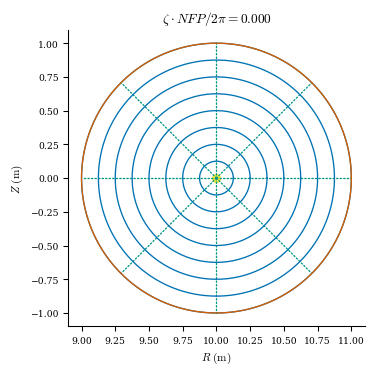

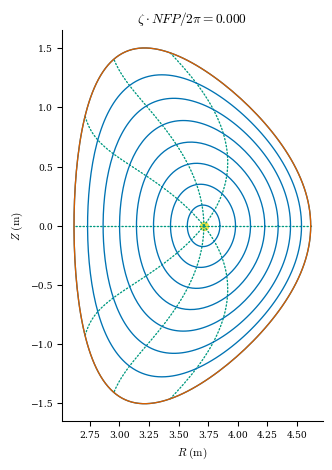

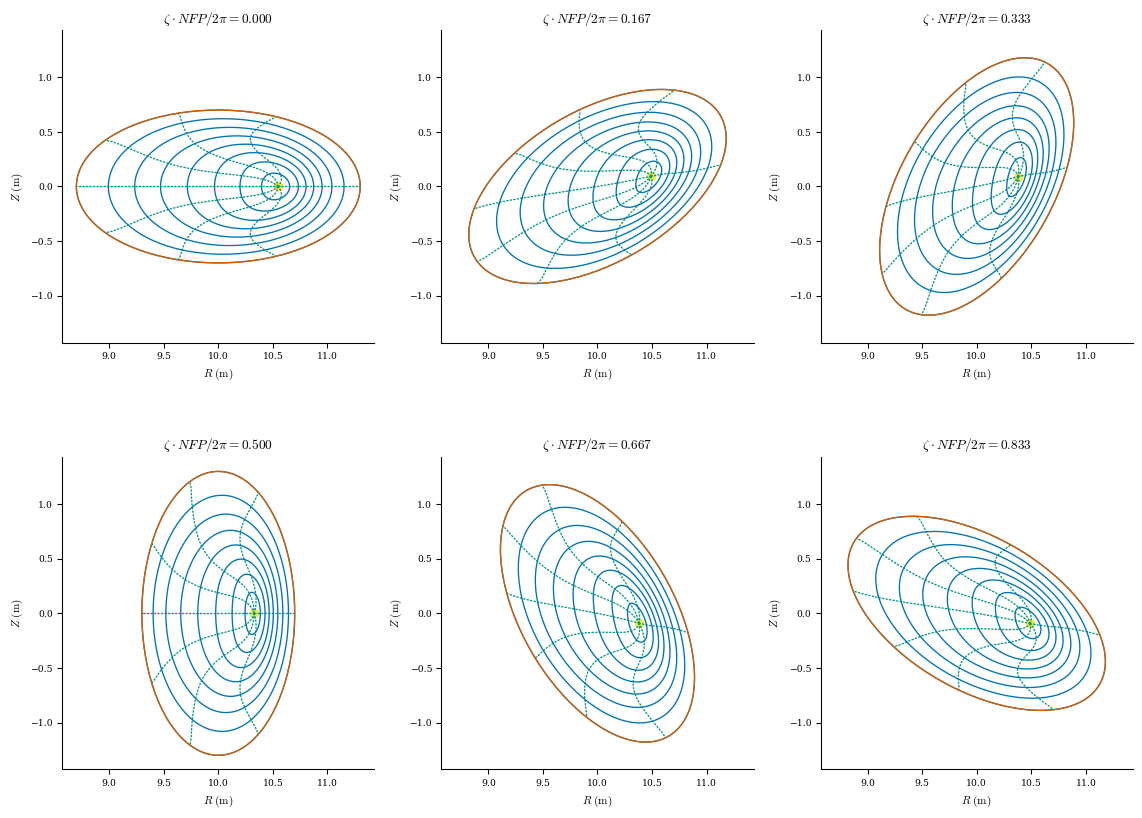

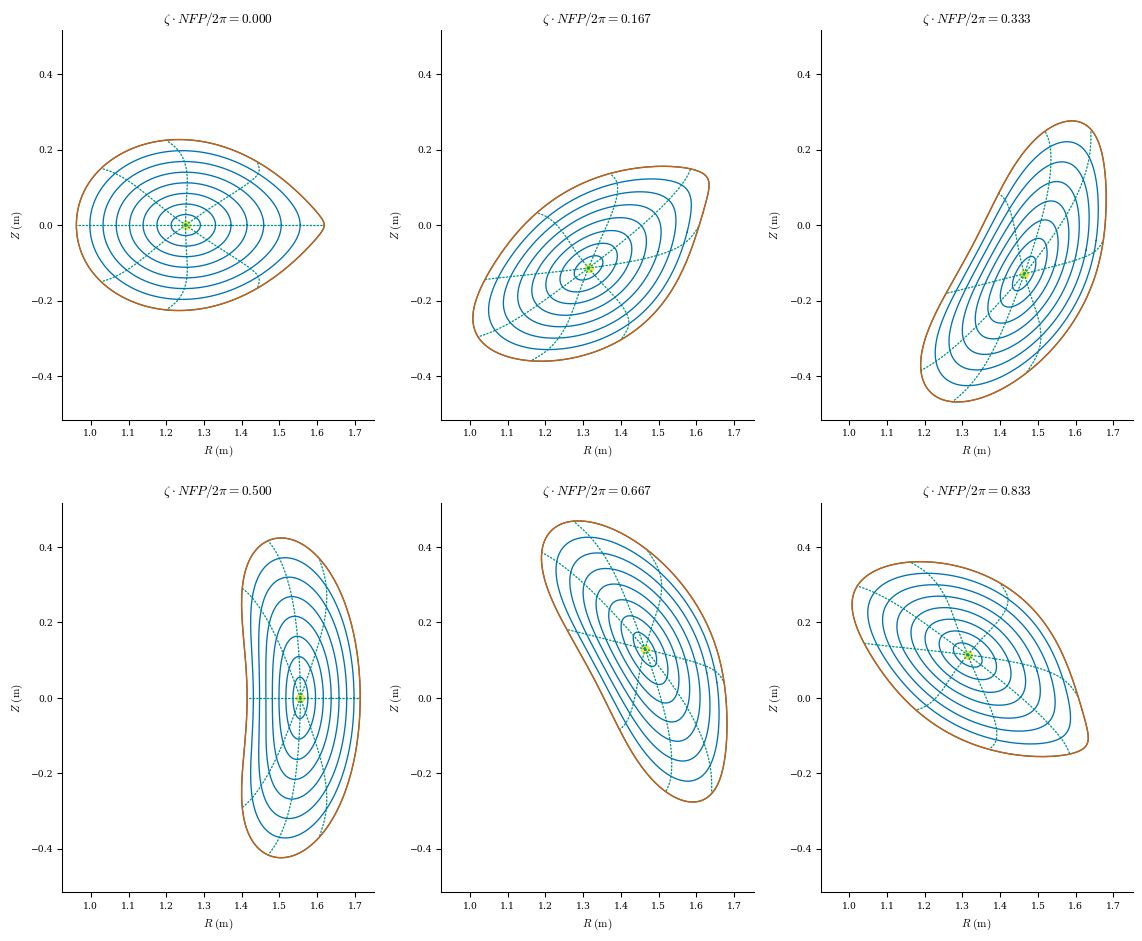

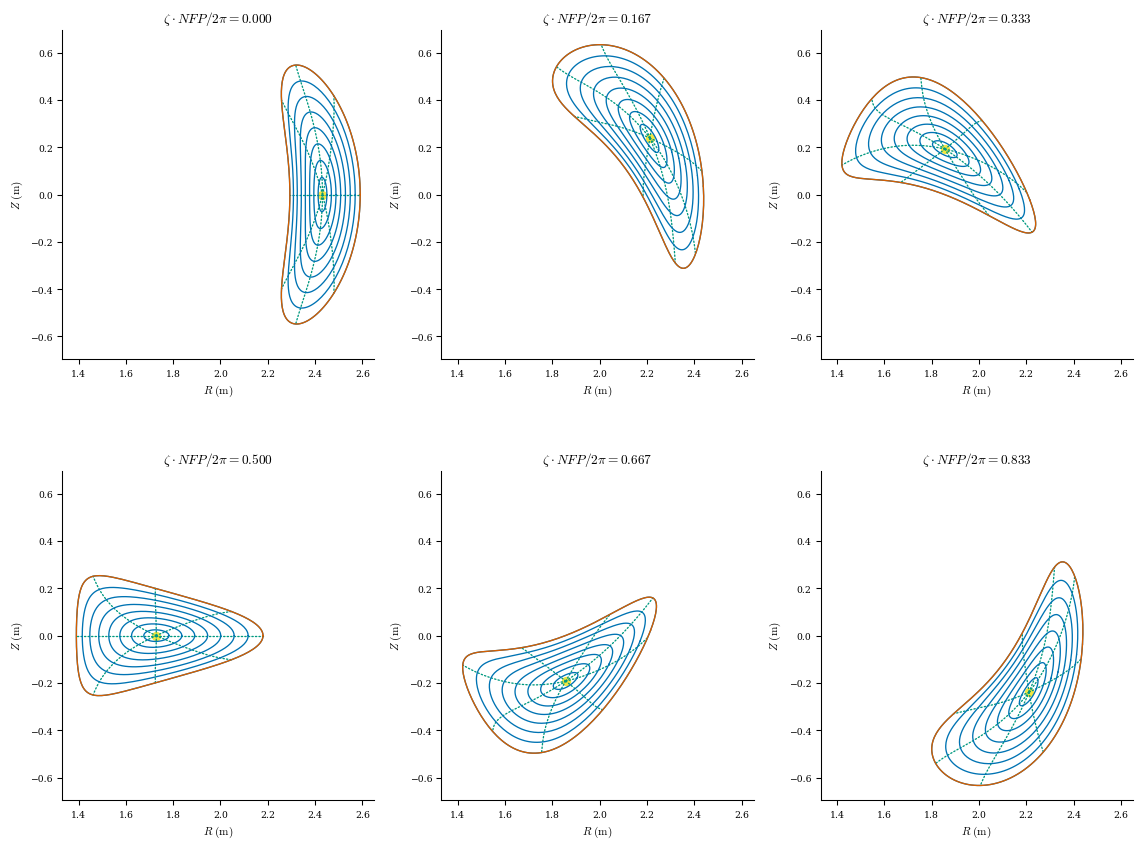

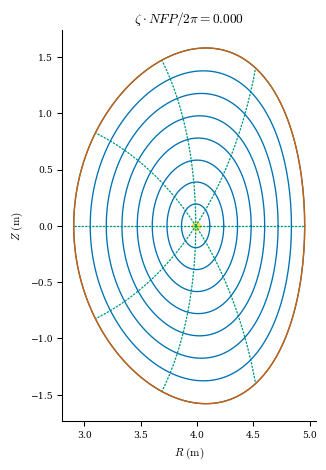

In [6]:
# to make sure equilibrium were solved correctly on my computer
for s in stellarators:
    plot_surfaces(s.eq)

# $\rho$ = 1 flux surface

In [7]:
for s in stellarators:
    s.print_values()

torus
Equilibrium at 0x7f8a40206640 (L=1, M=1, N=0, NFP=1, sym=False, spectral_indexing=ansi)
Precomputing transforms
grid.spacing(dr,dt,dz) [1.0000 1.2566 6.2832]
1. DESC Well: M. Landreman eq. 3.2 with rho * d/drho [-3.5527e-16]
2. DESC Well: M. Landreman eq. 3.2 [-1.7764e-16]
DESC DCurr [0.0000]
DESC DGeod [-0.0000]
DESC DMerc [0.0000]
DESC DShear [0.0000]
DESC DWell [0.0000]
volume [197.3921]
data["V"] 197.39208802178715

DSHAPE
Equilibrium at 0x7f89f41c0c40 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
Precomputing transforms
grid.spacing(dr,dt,dz) [1.2599 0.1466 7.9163]
1. DESC Well: M. Landreman eq. 3.2 with rho * d/drho [0.0629]
2. DESC Well: M. Landreman eq. 3.2 [0.0369]
DESC DCurr [-0.0008]
DESC DGeod [-1.7297e-06]
DESC DMerc [0.1115]
DESC DShear [0.1122]
DESC DWell [0.0000]
volume [99.4570]
data["V"] 99.1767790025823

HELIOTRON
Equilibrium at 0x7f89f446f5e0 (L=24, M=12, N=3, NFP=19.0, sym=1, spectral_indexing=fringe)
Precomputing transforms
grid.spacing(dr,dt,d

# Magnetic well plots
Although the symmetry bug is fixed, forcing it off results in a closer match between the VMEC and DESC plots.

In [8]:
for s in stellarators:
    s.compute_plot(use_quad_grid=False)

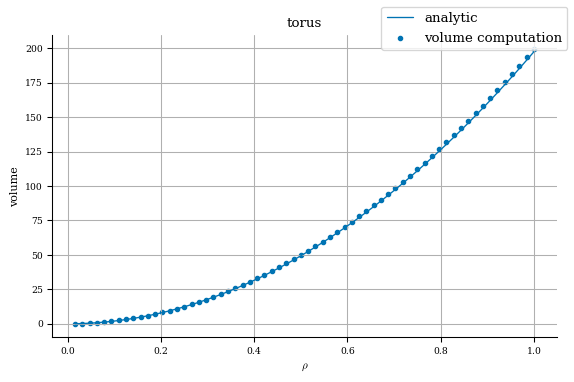

In [9]:
# compare volume computation to known analytic case for torus
fig, ax = plt.subplots()
y = "volume"
rho, volume = torus.st[y]
ax.scatter(rho, volume, label=y + " computation", s=10)
ax.plot(rho, 20 * (np.pi * rho) ** 2, label="analytic")
ax.set(xlabel=r"$\rho$", ylabel=y, title=torus.name)
ax.grid()
fig.legend()

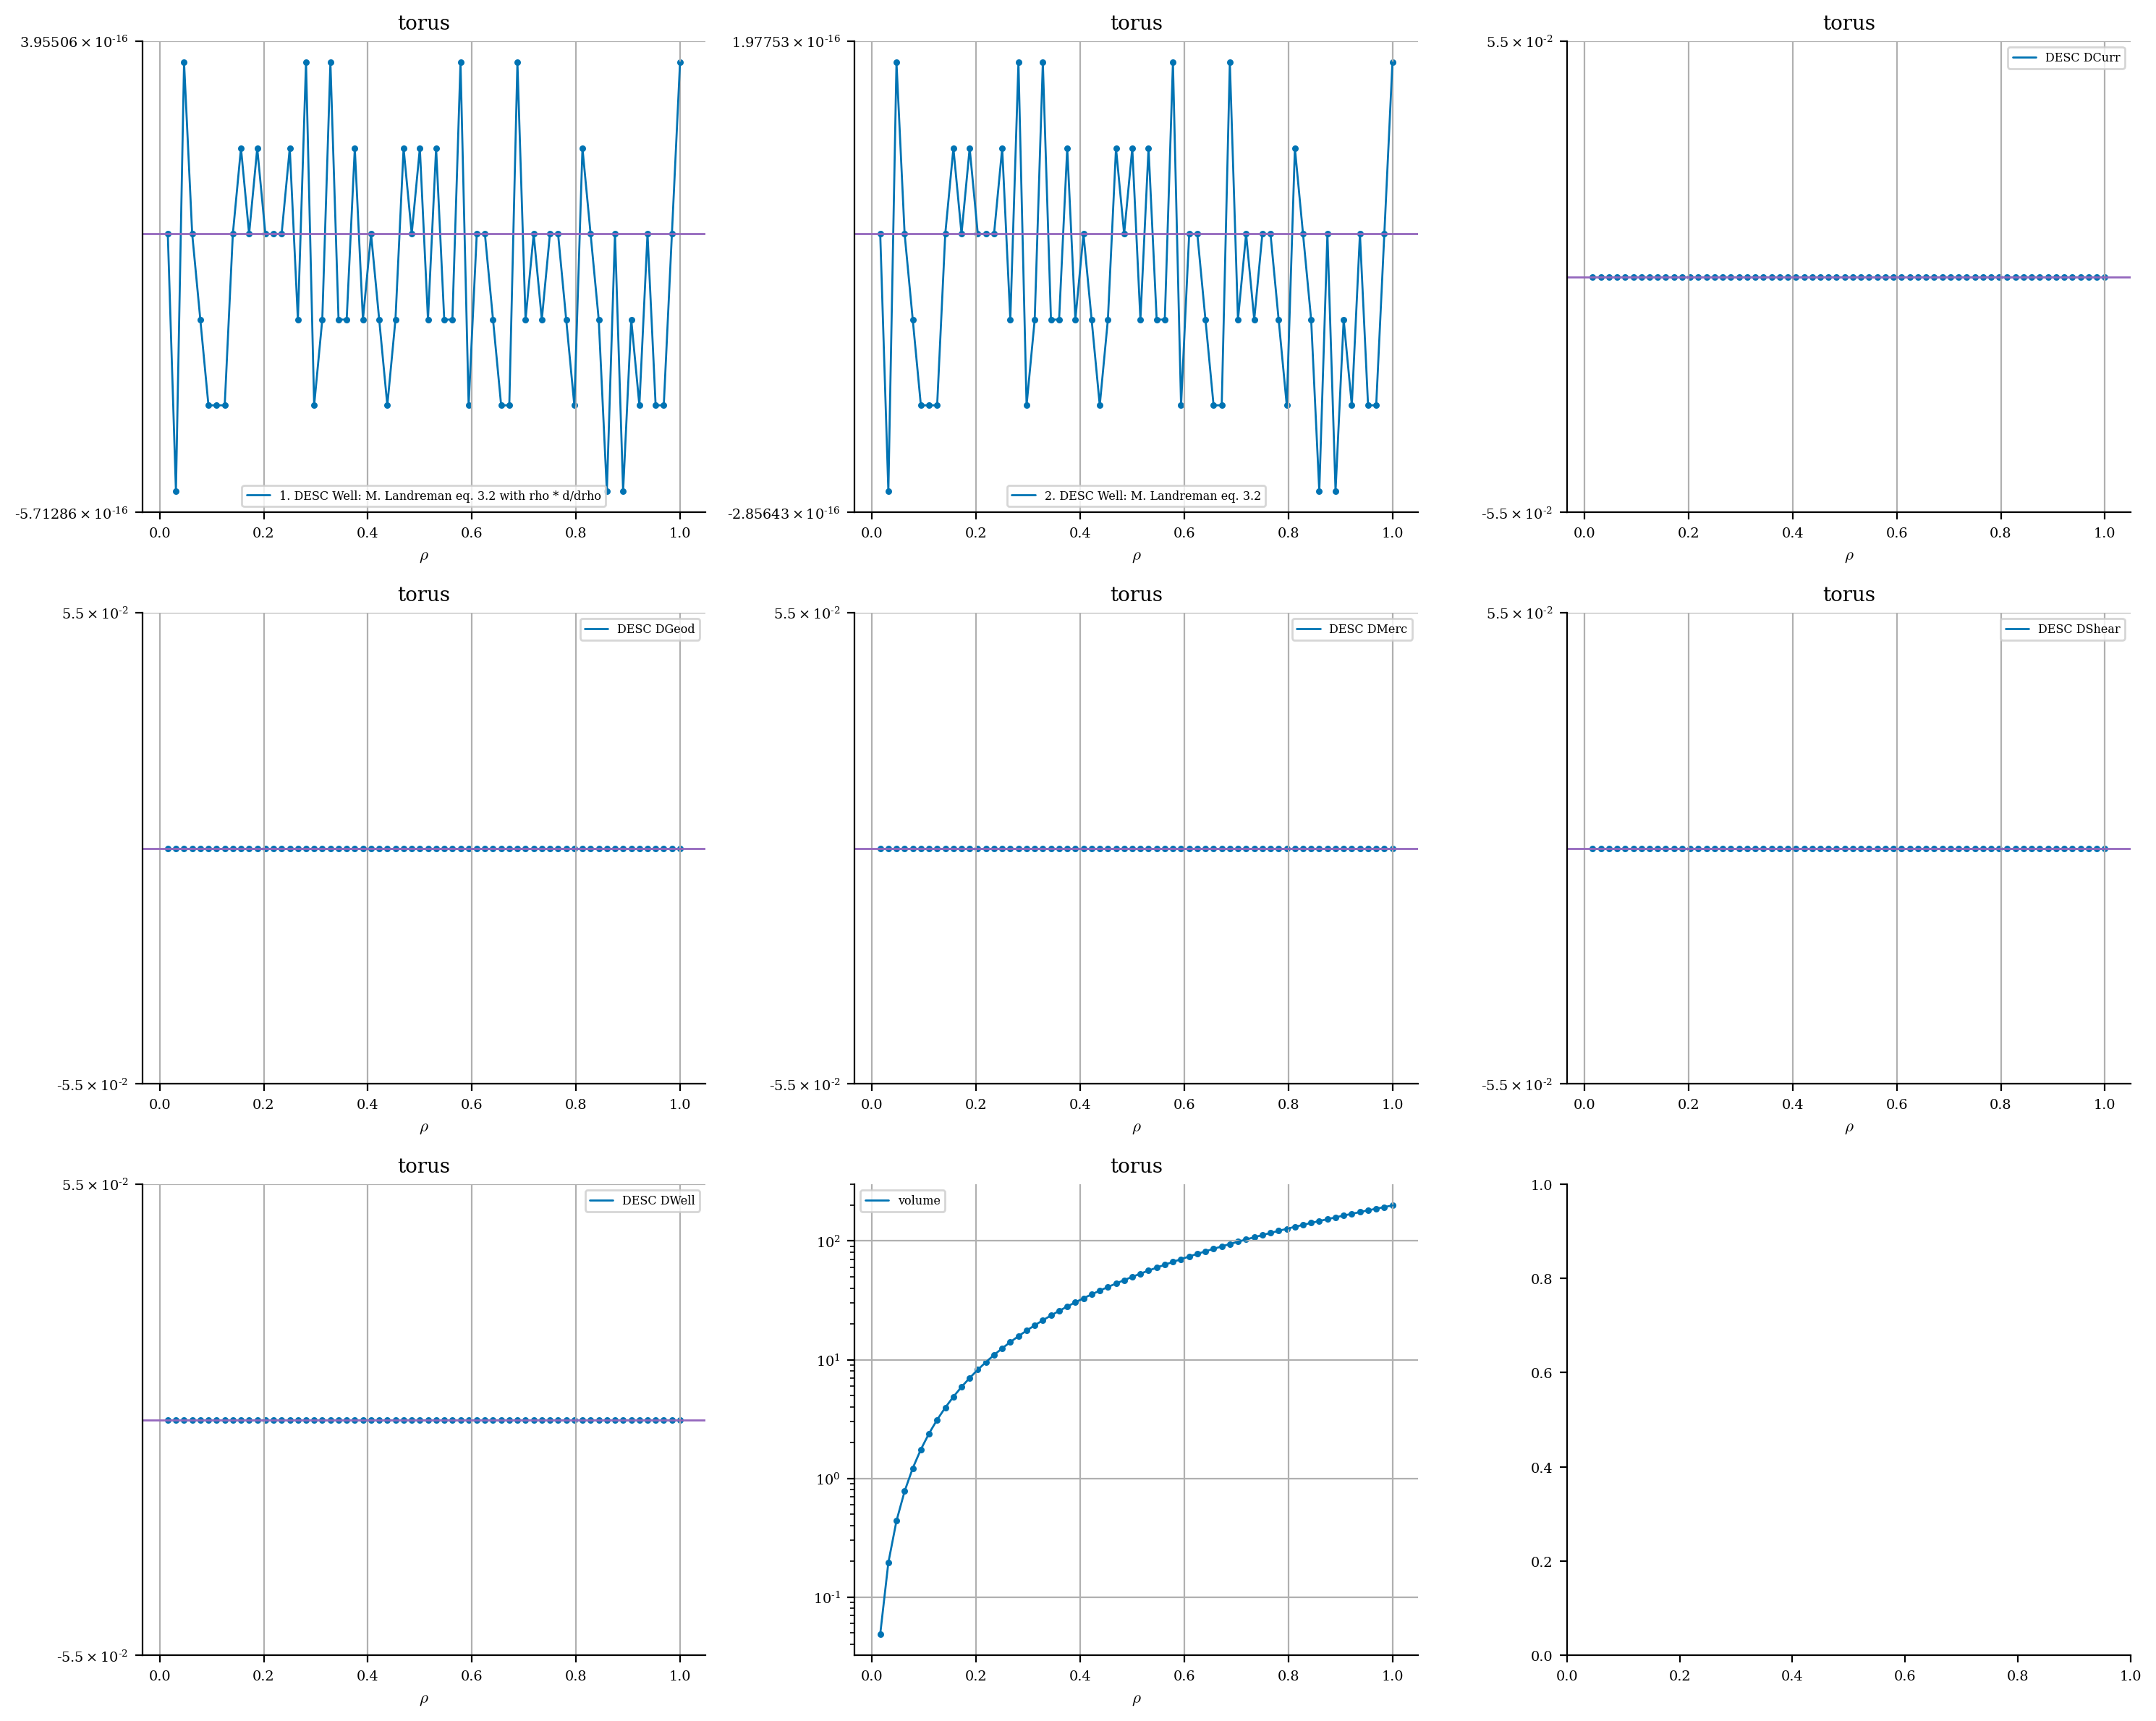

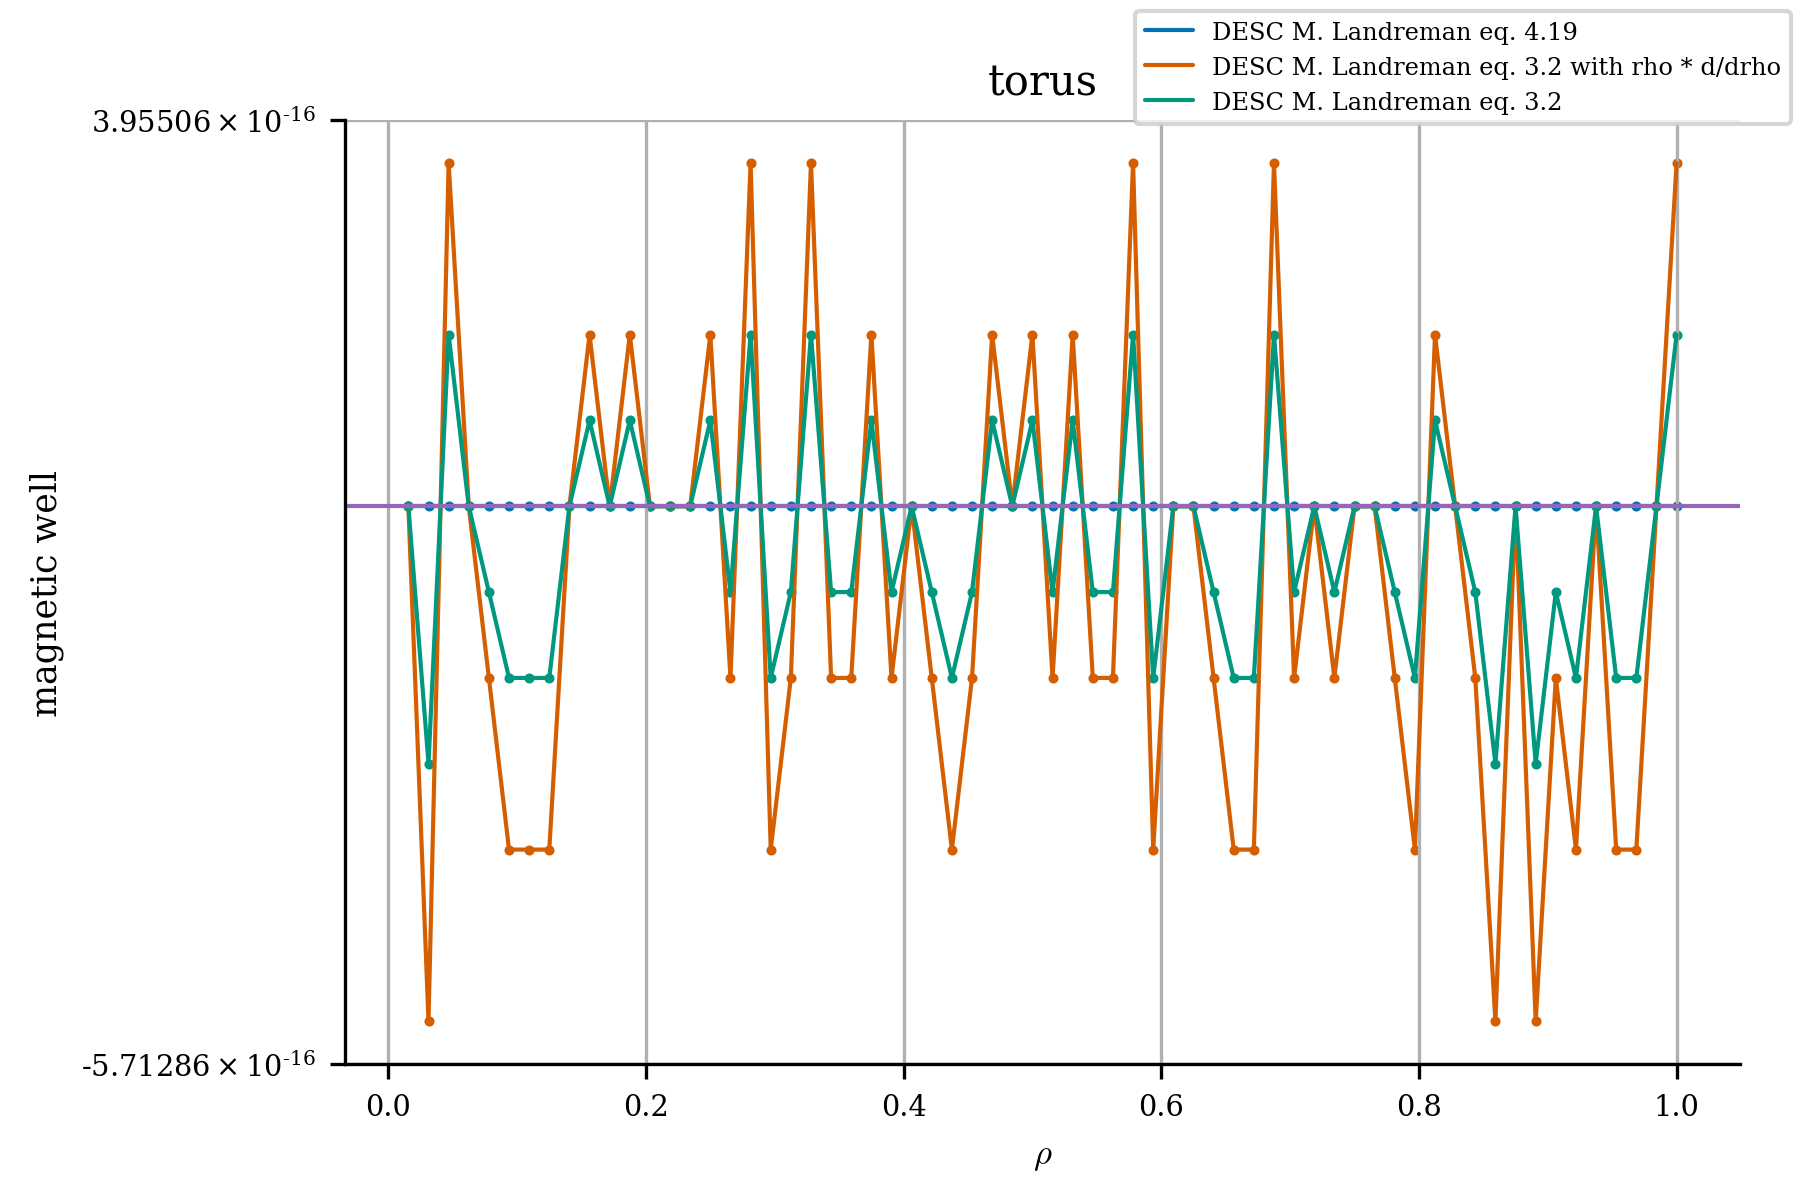

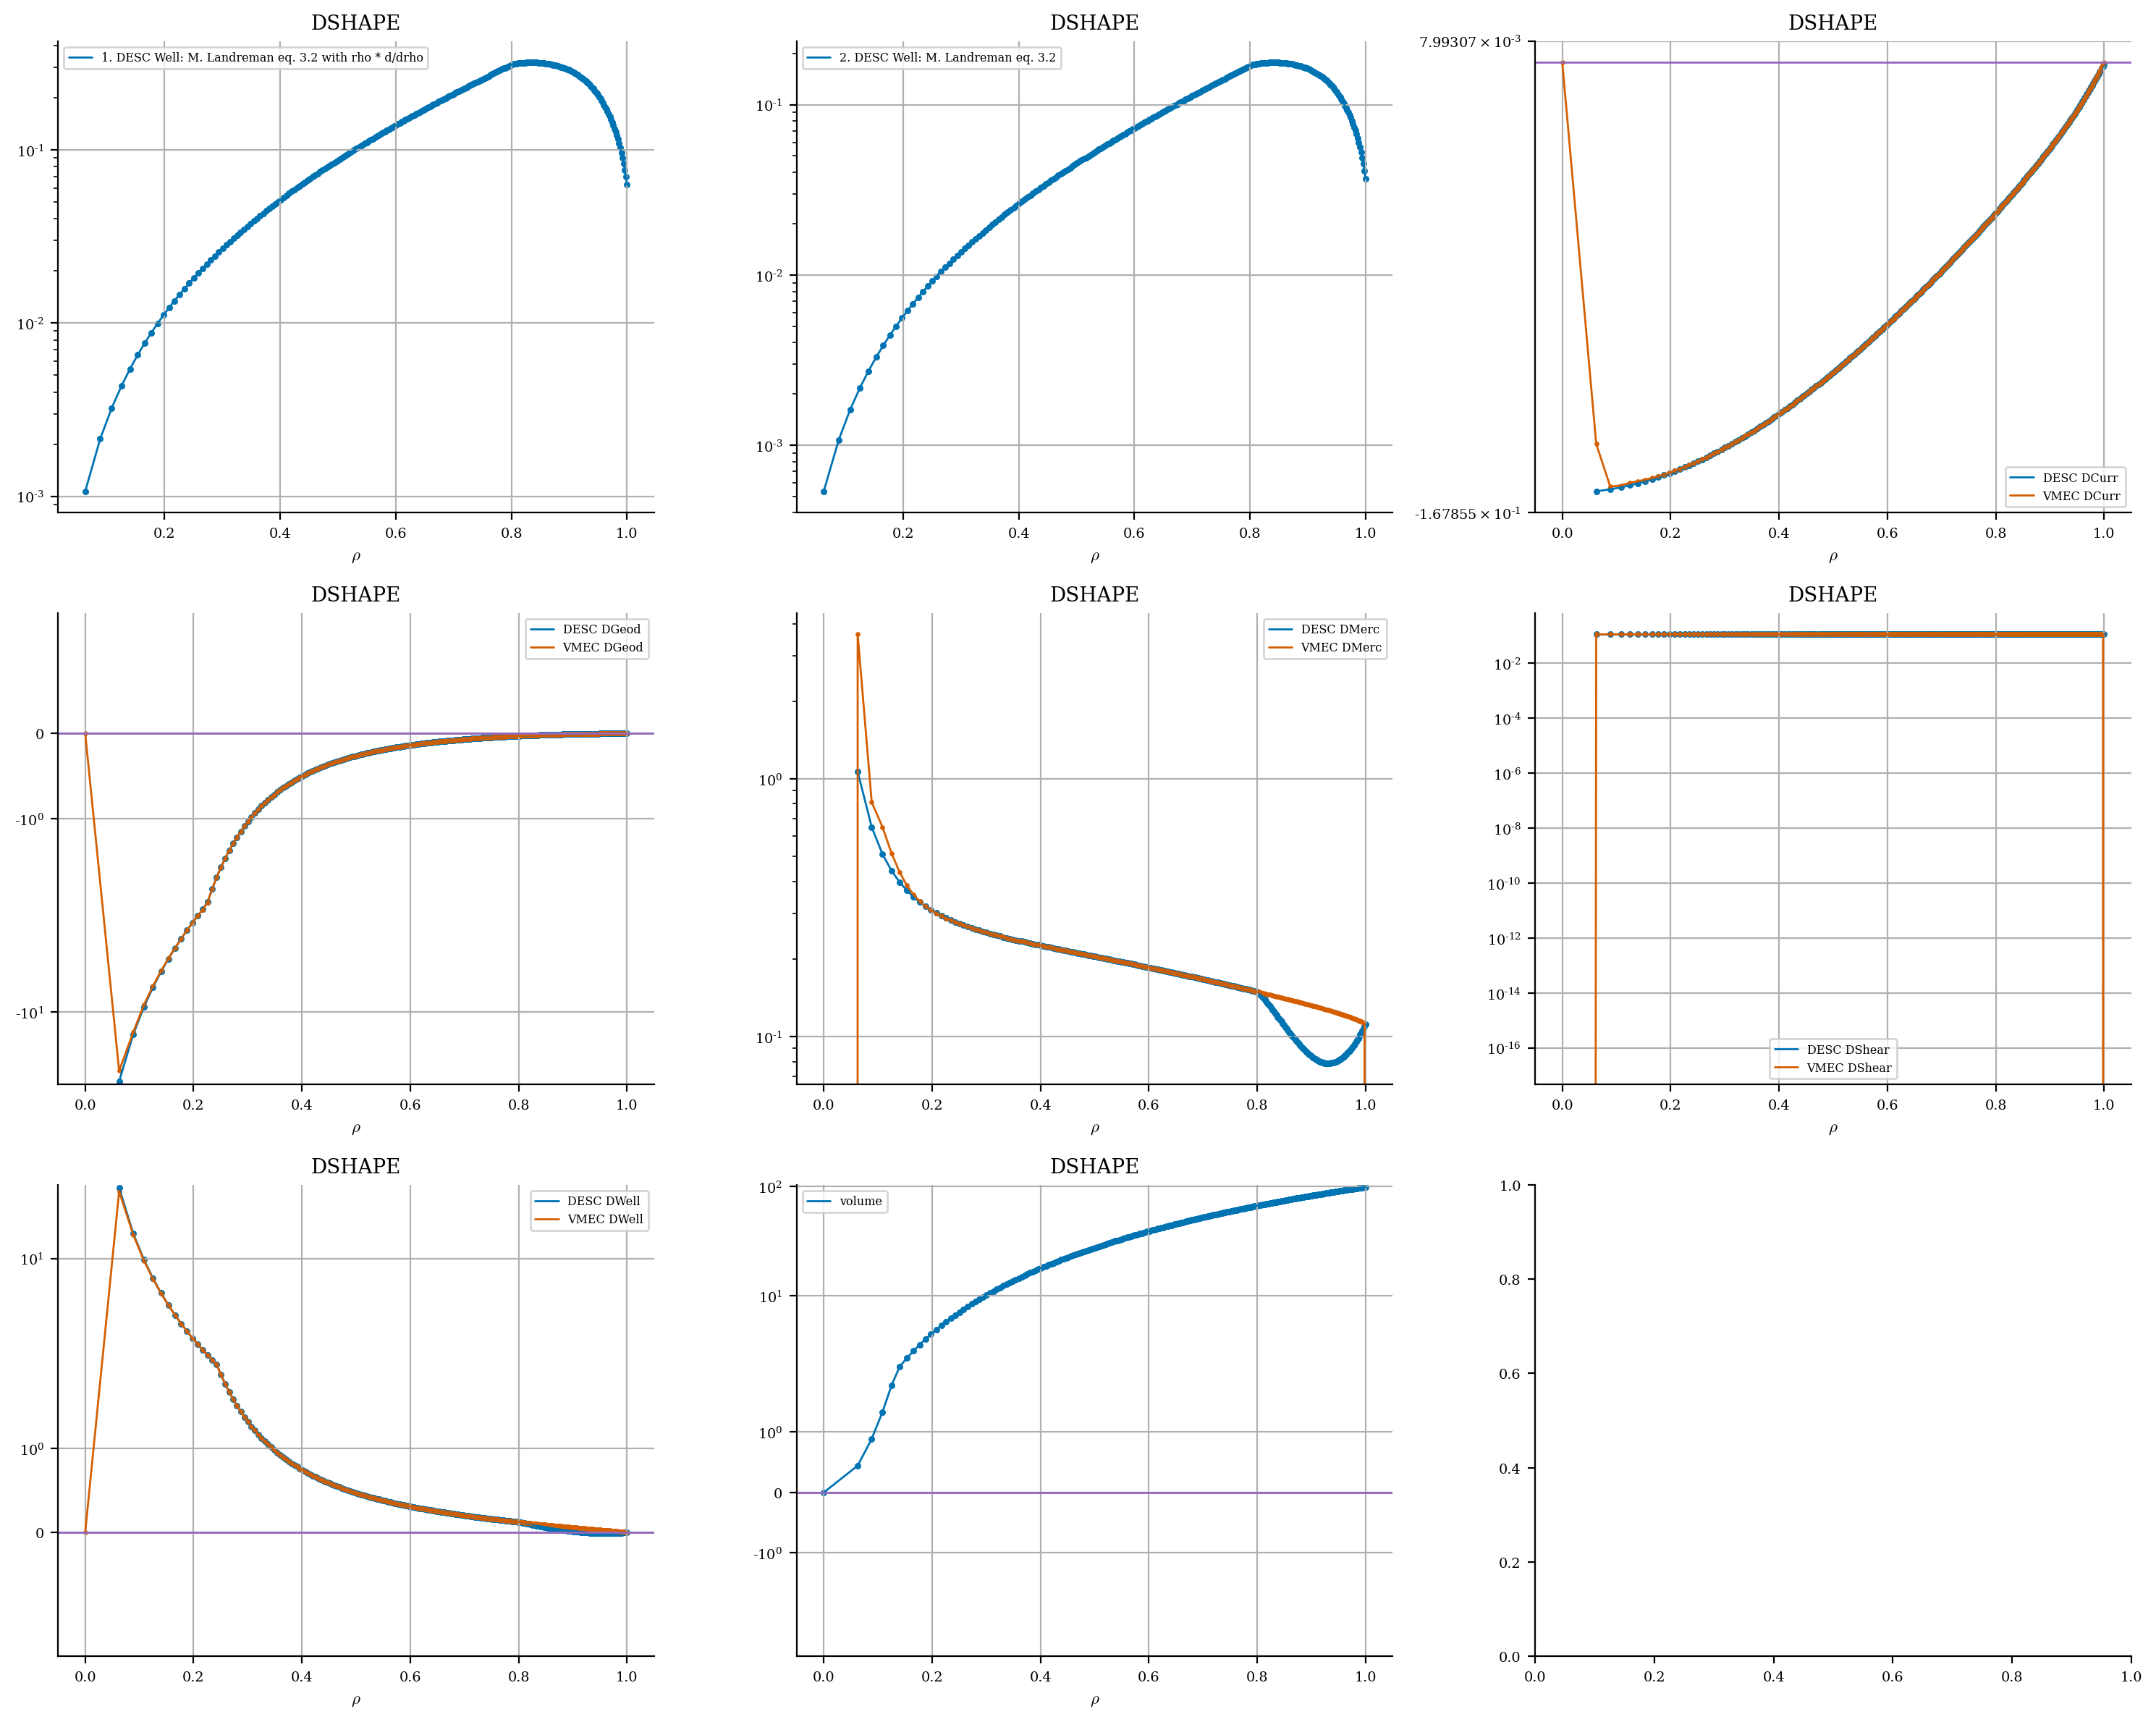

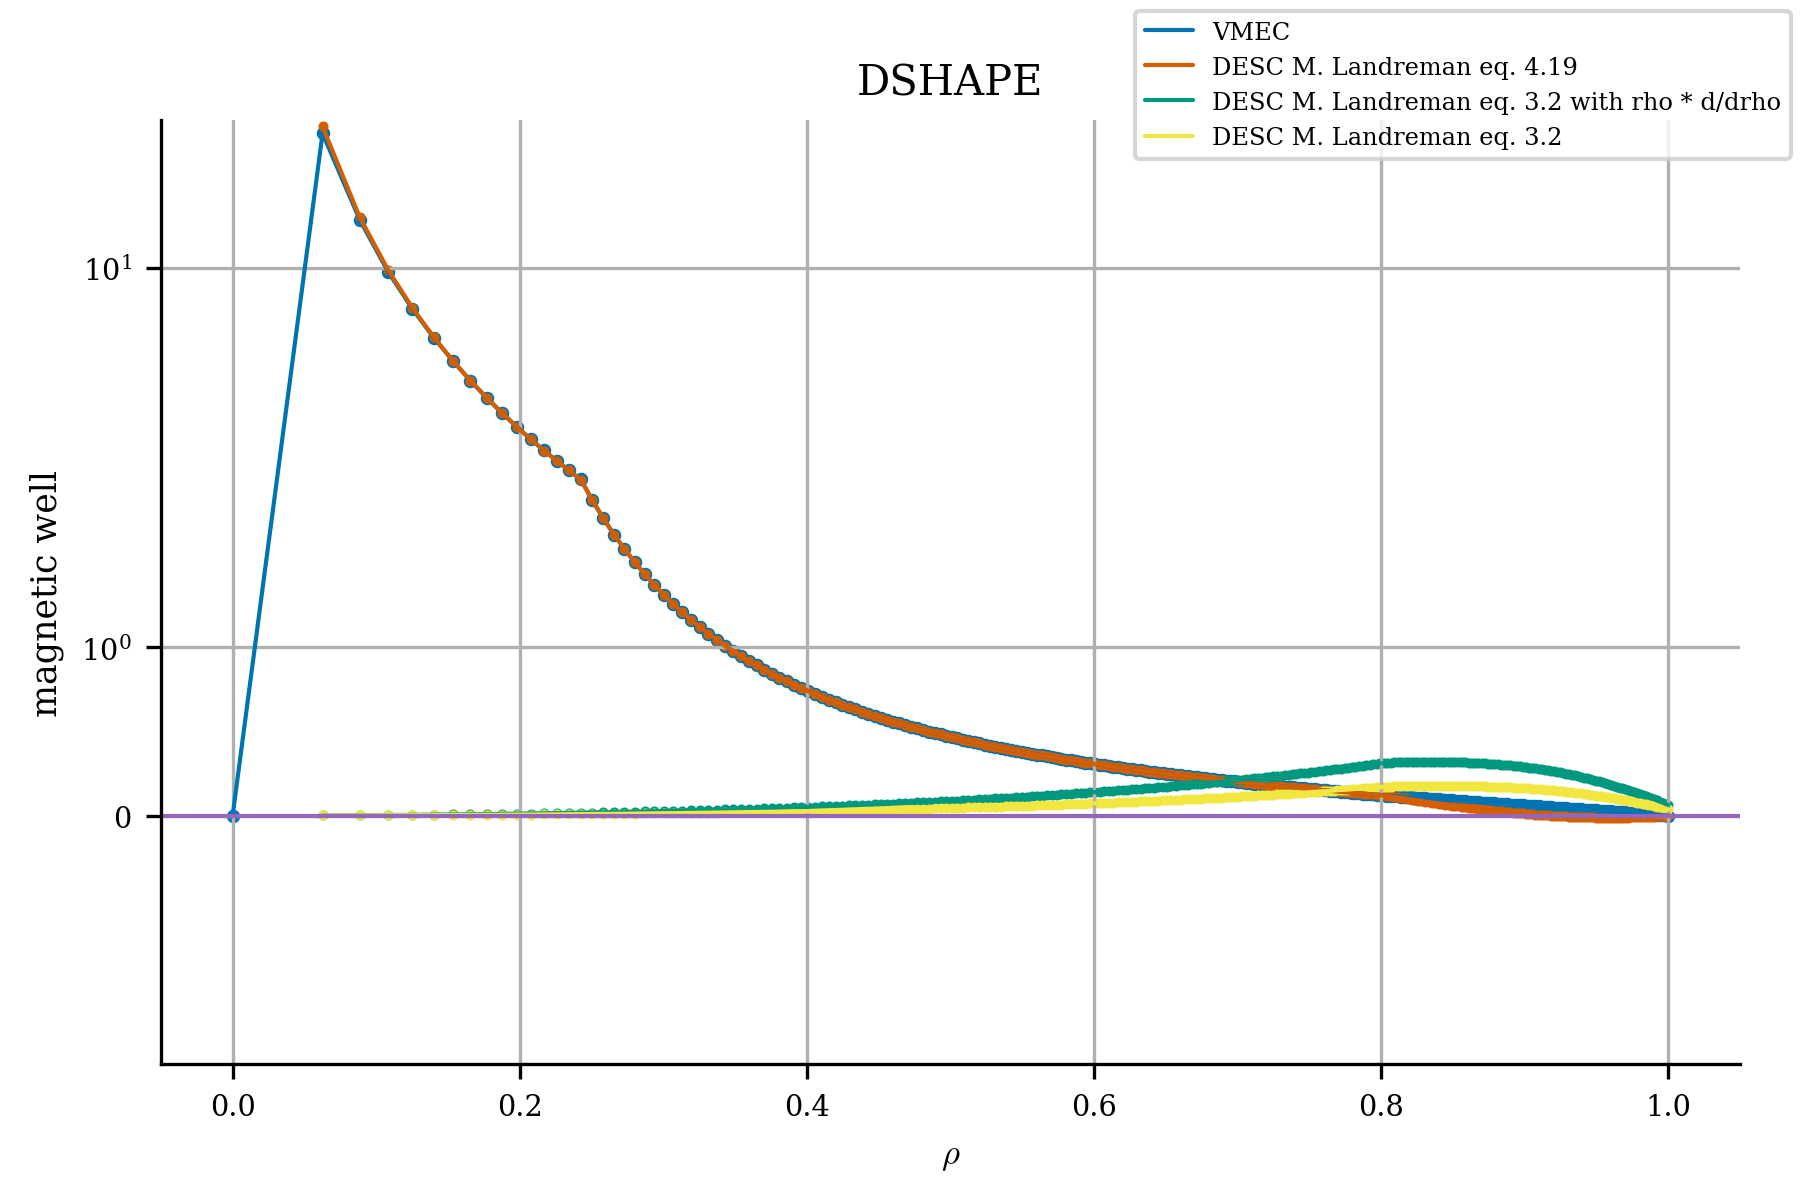

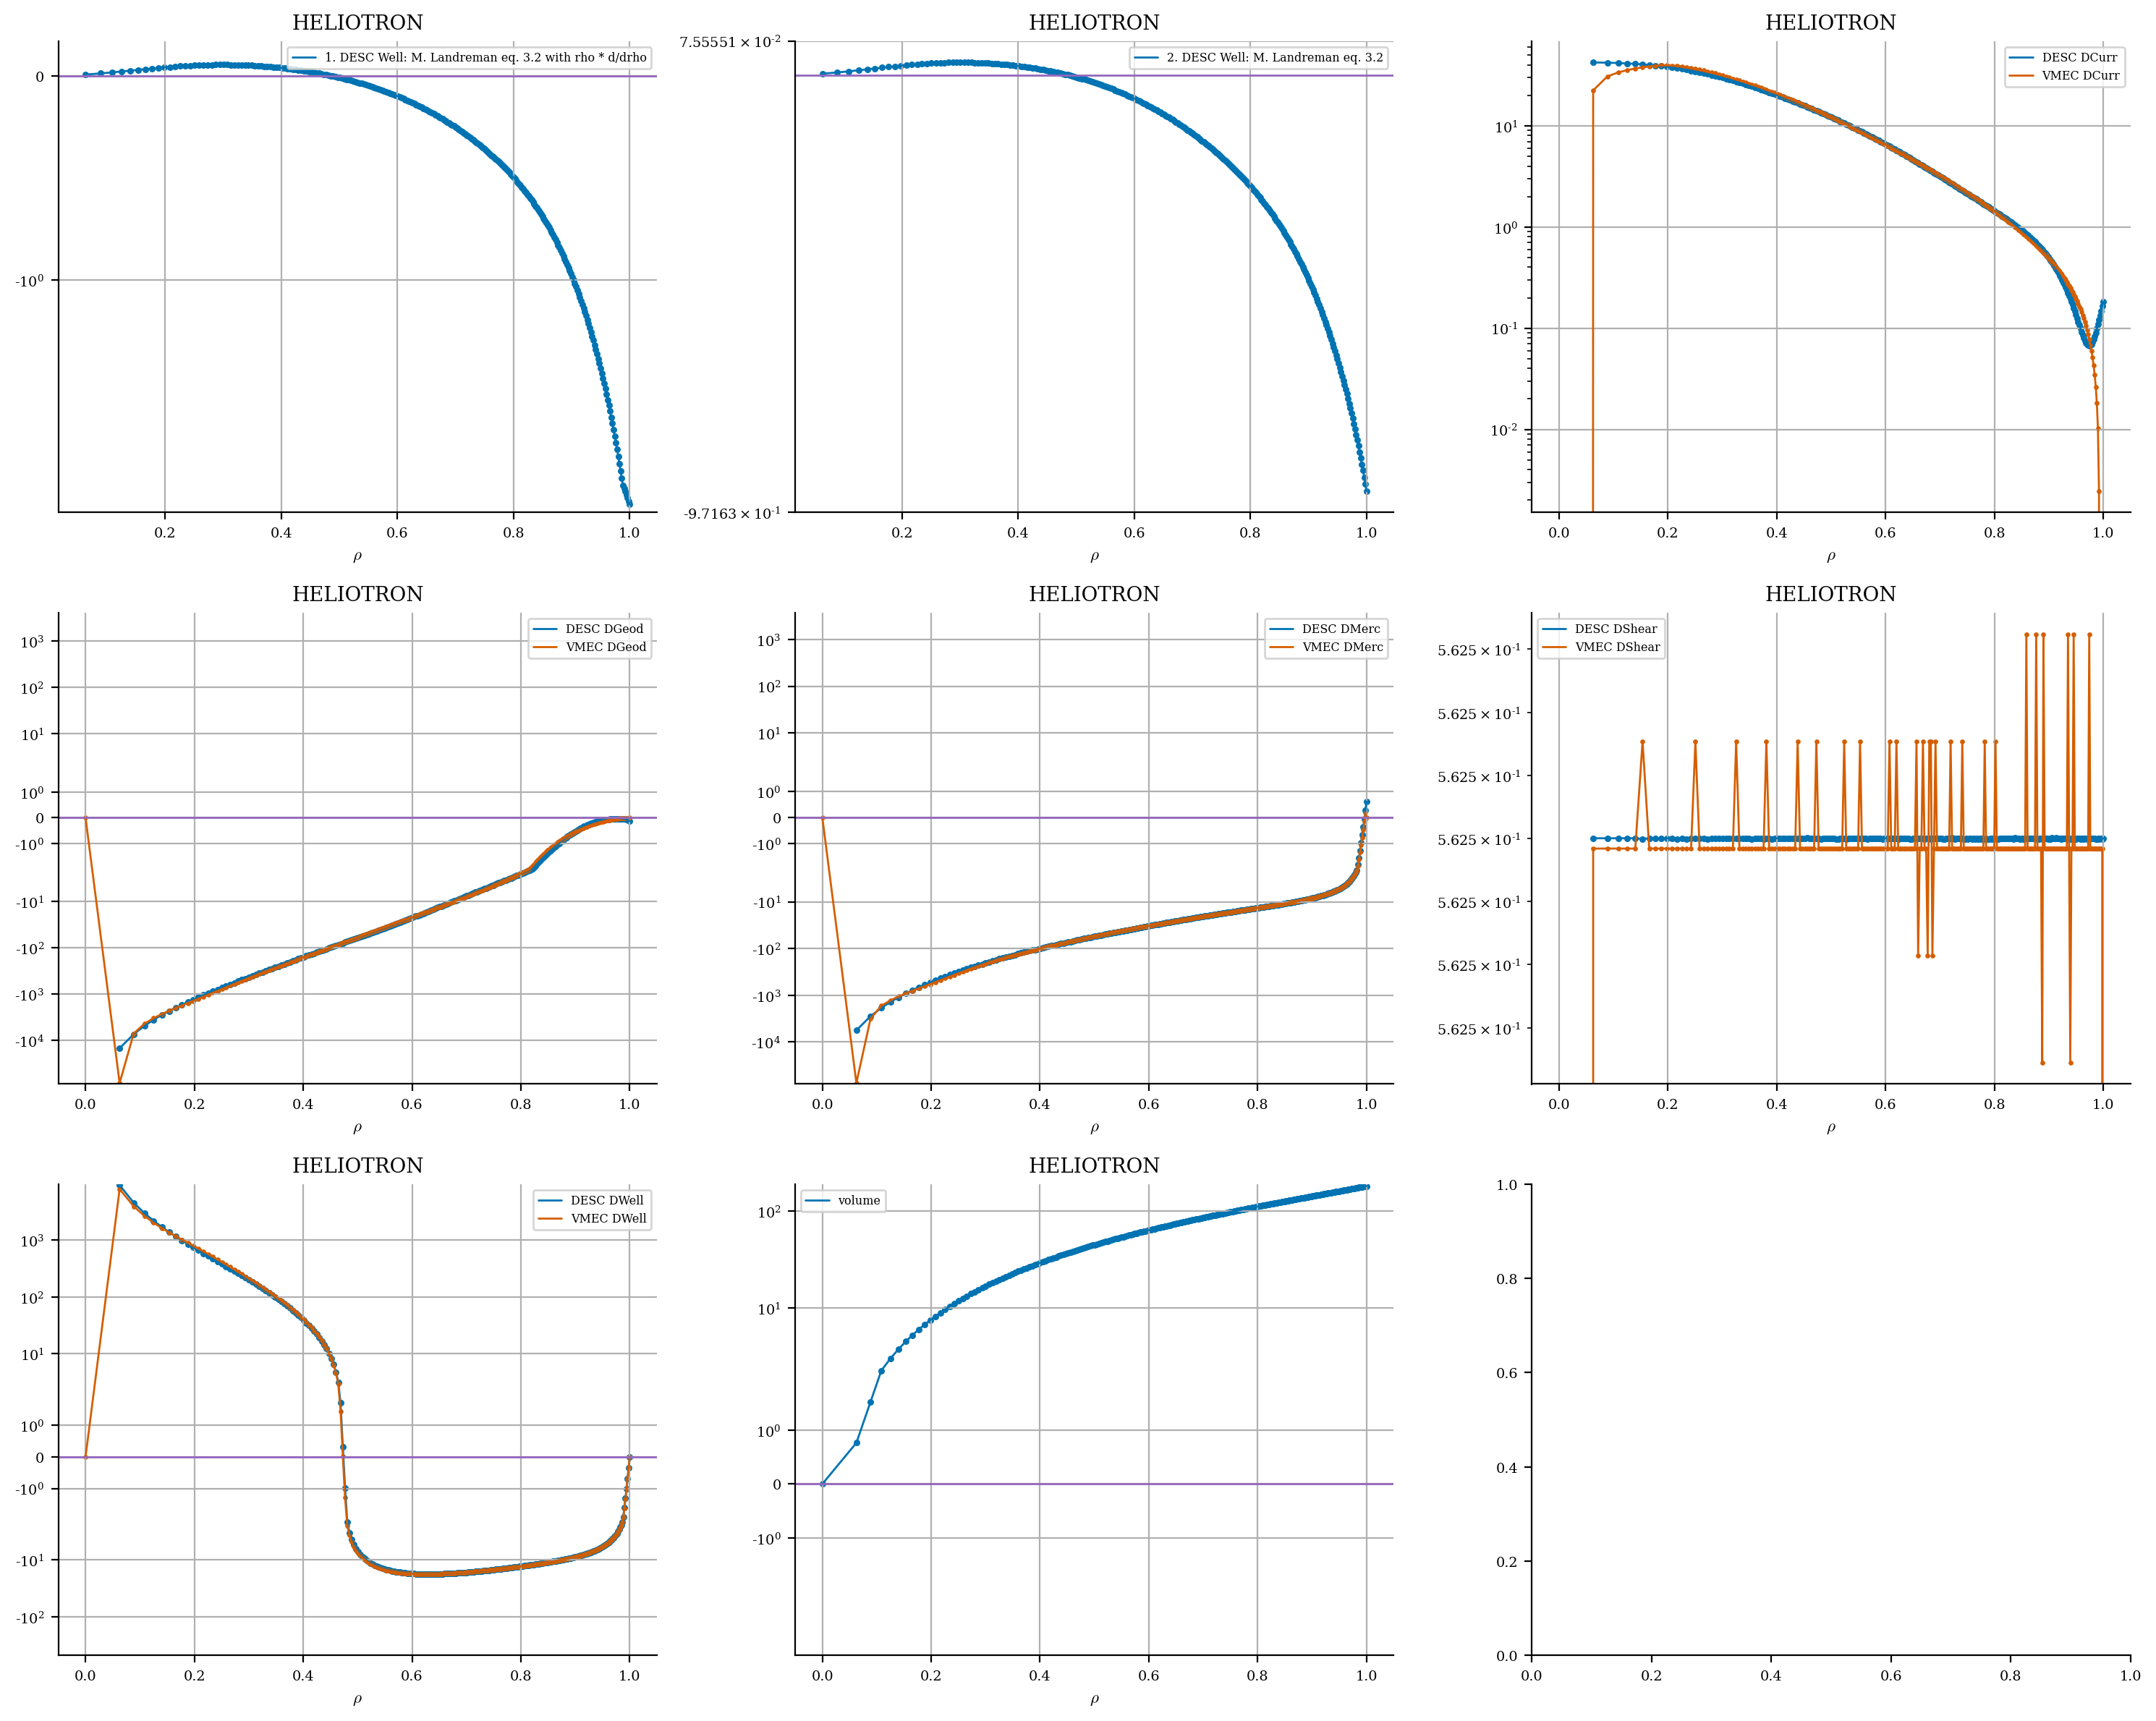

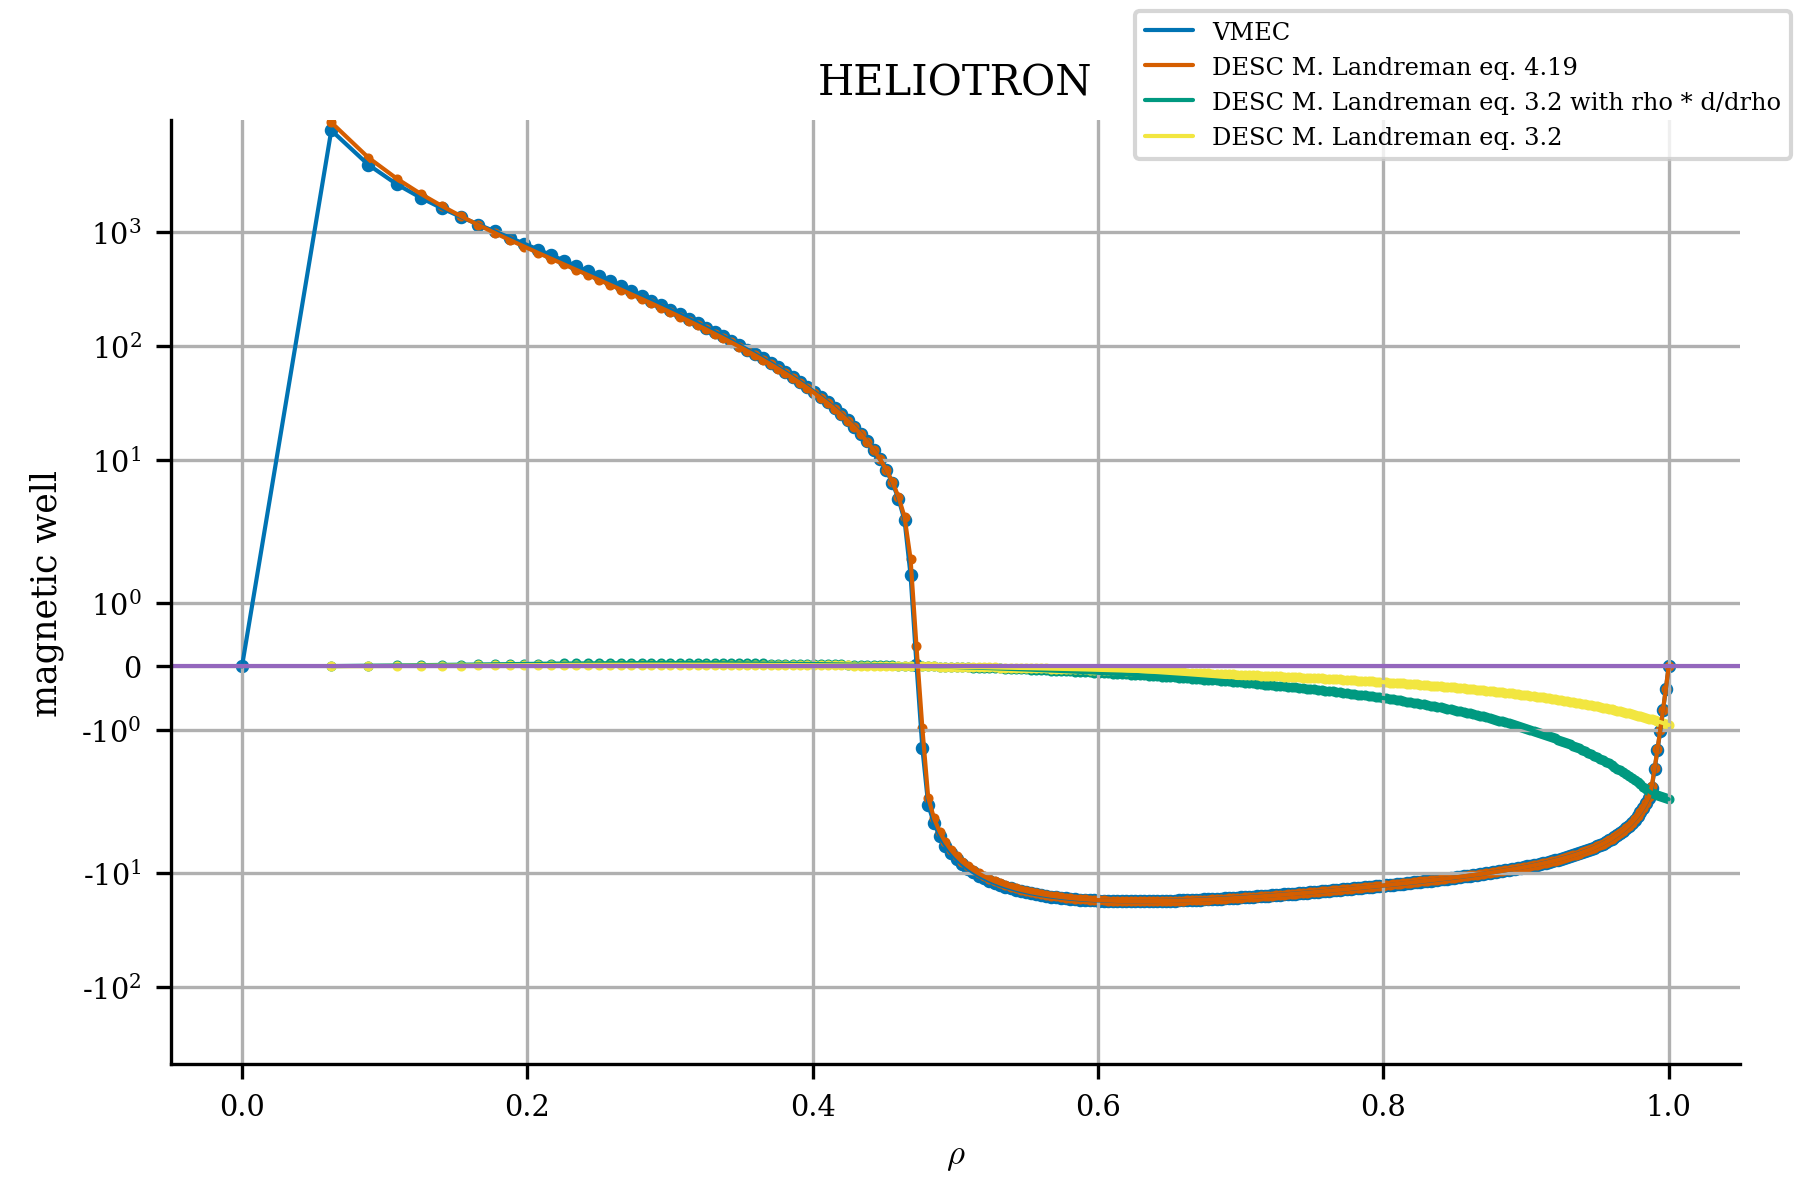

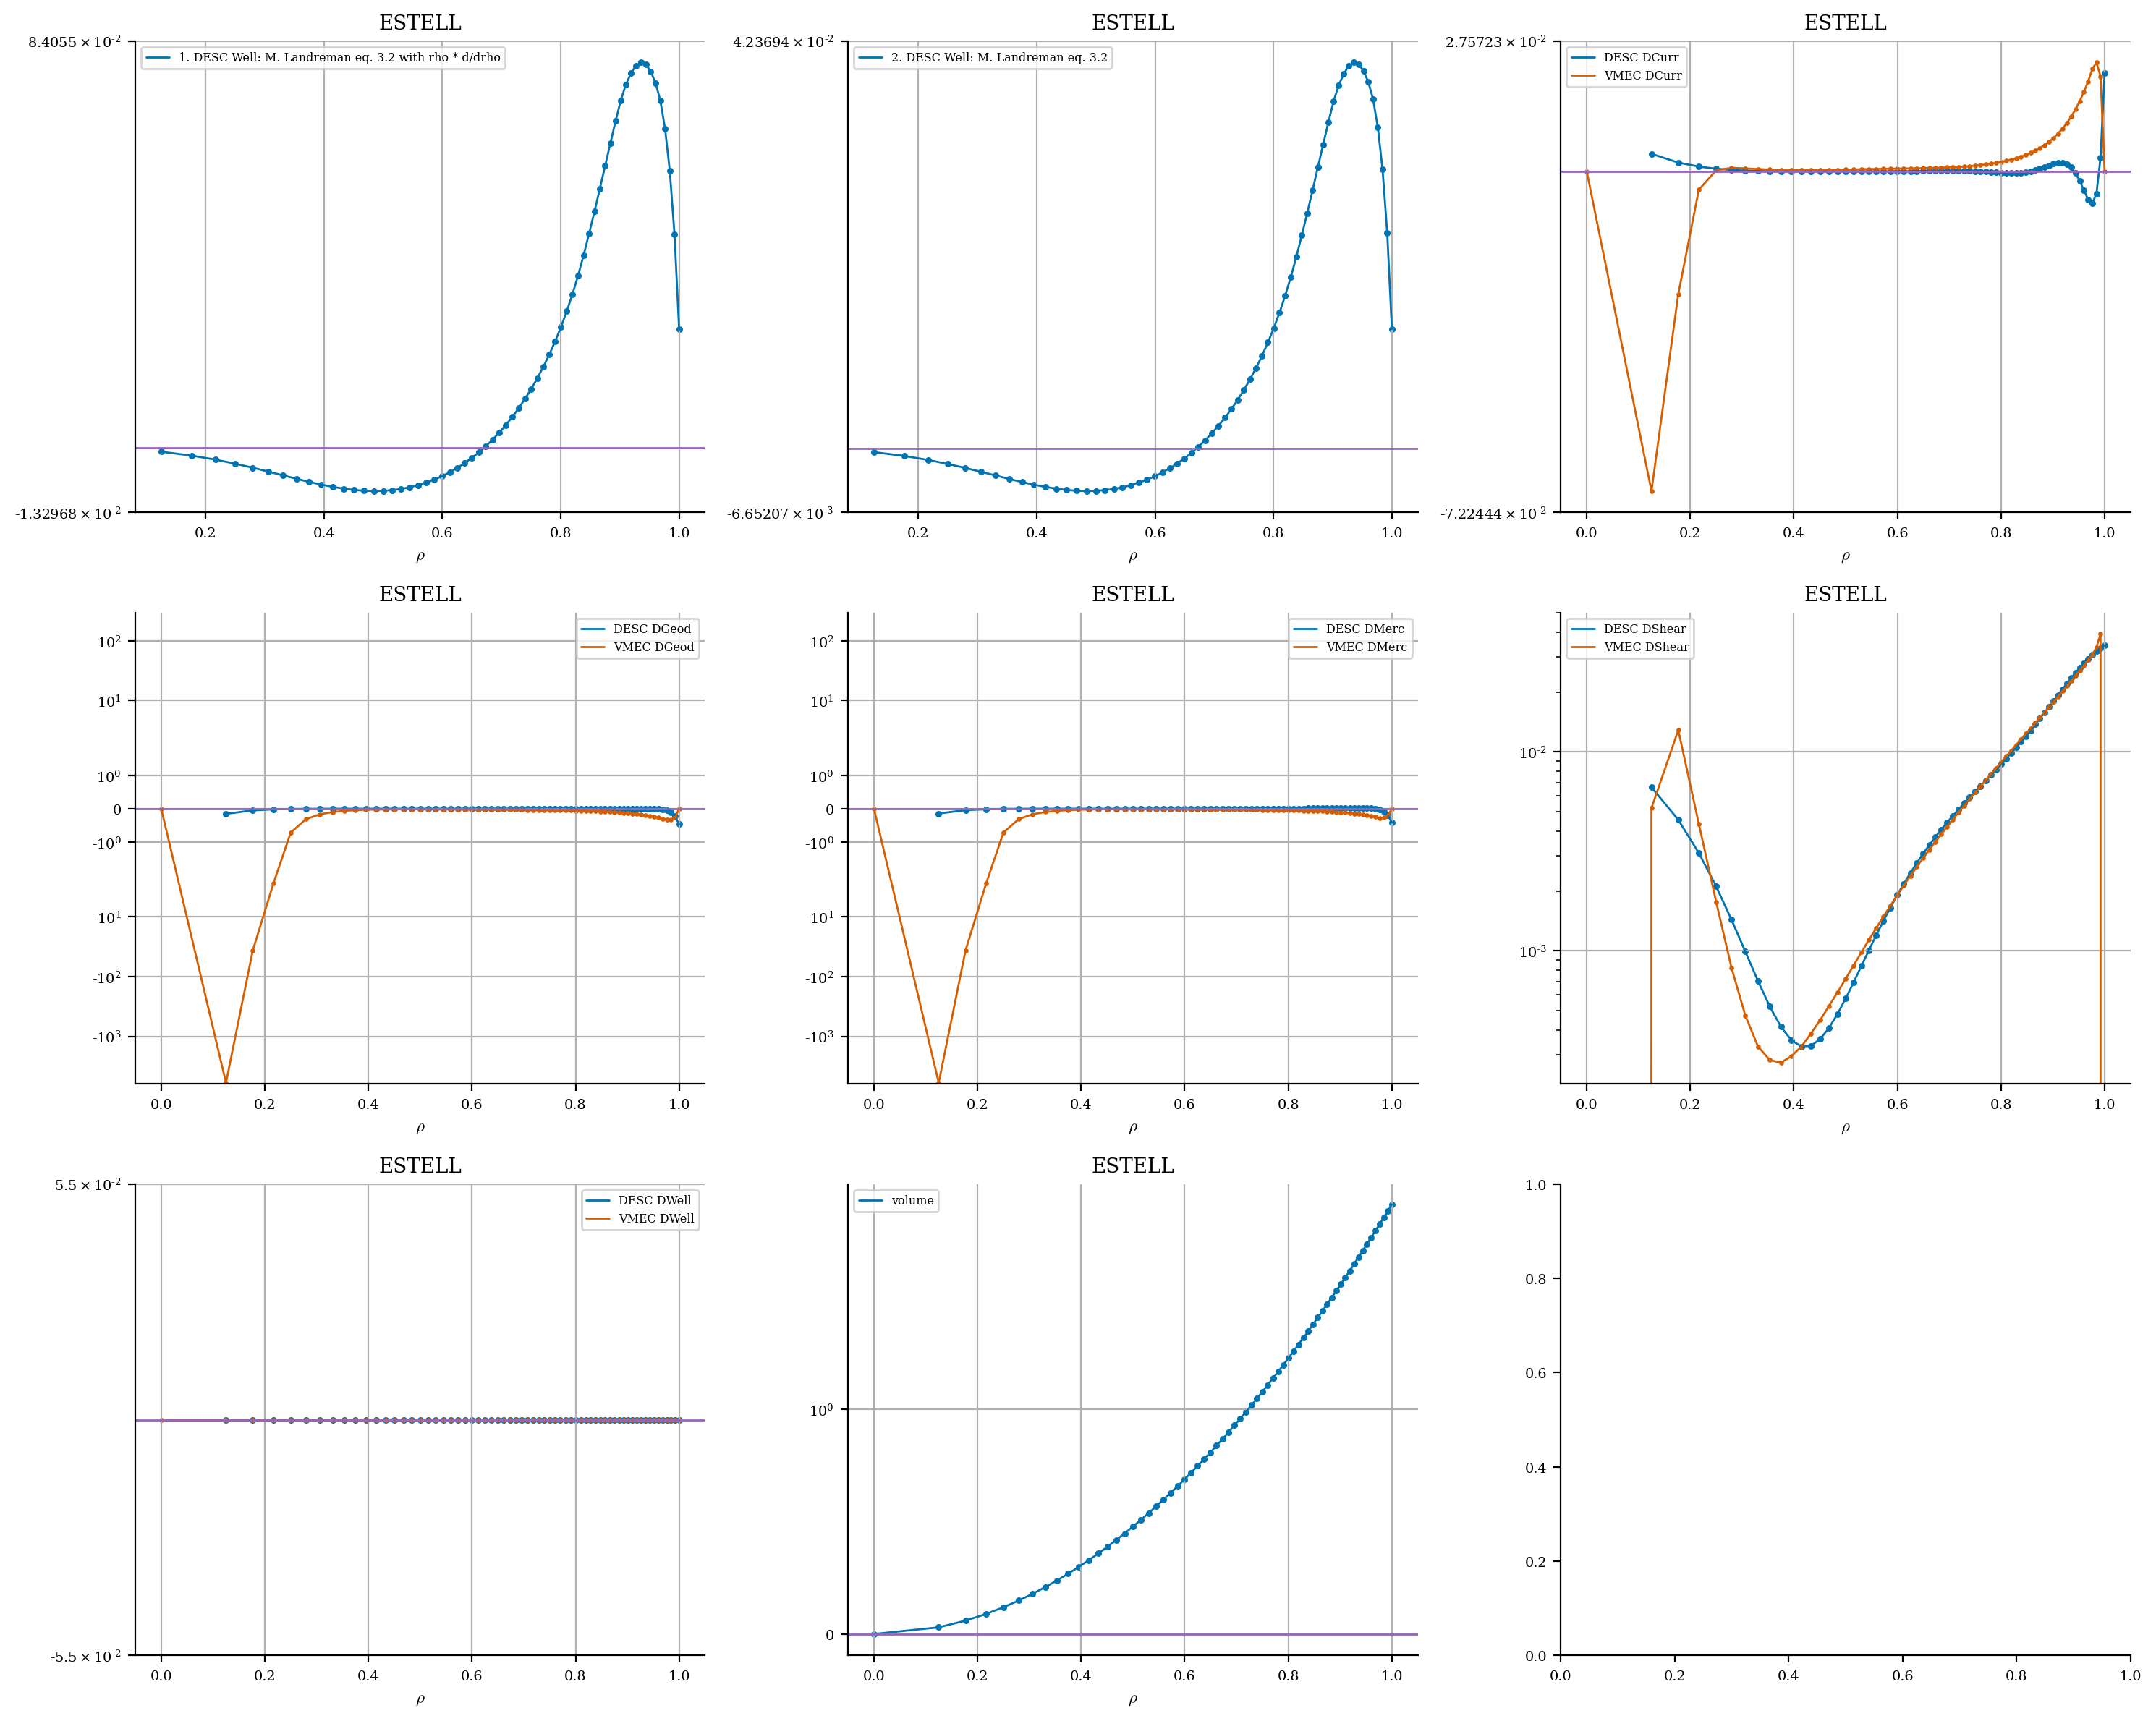

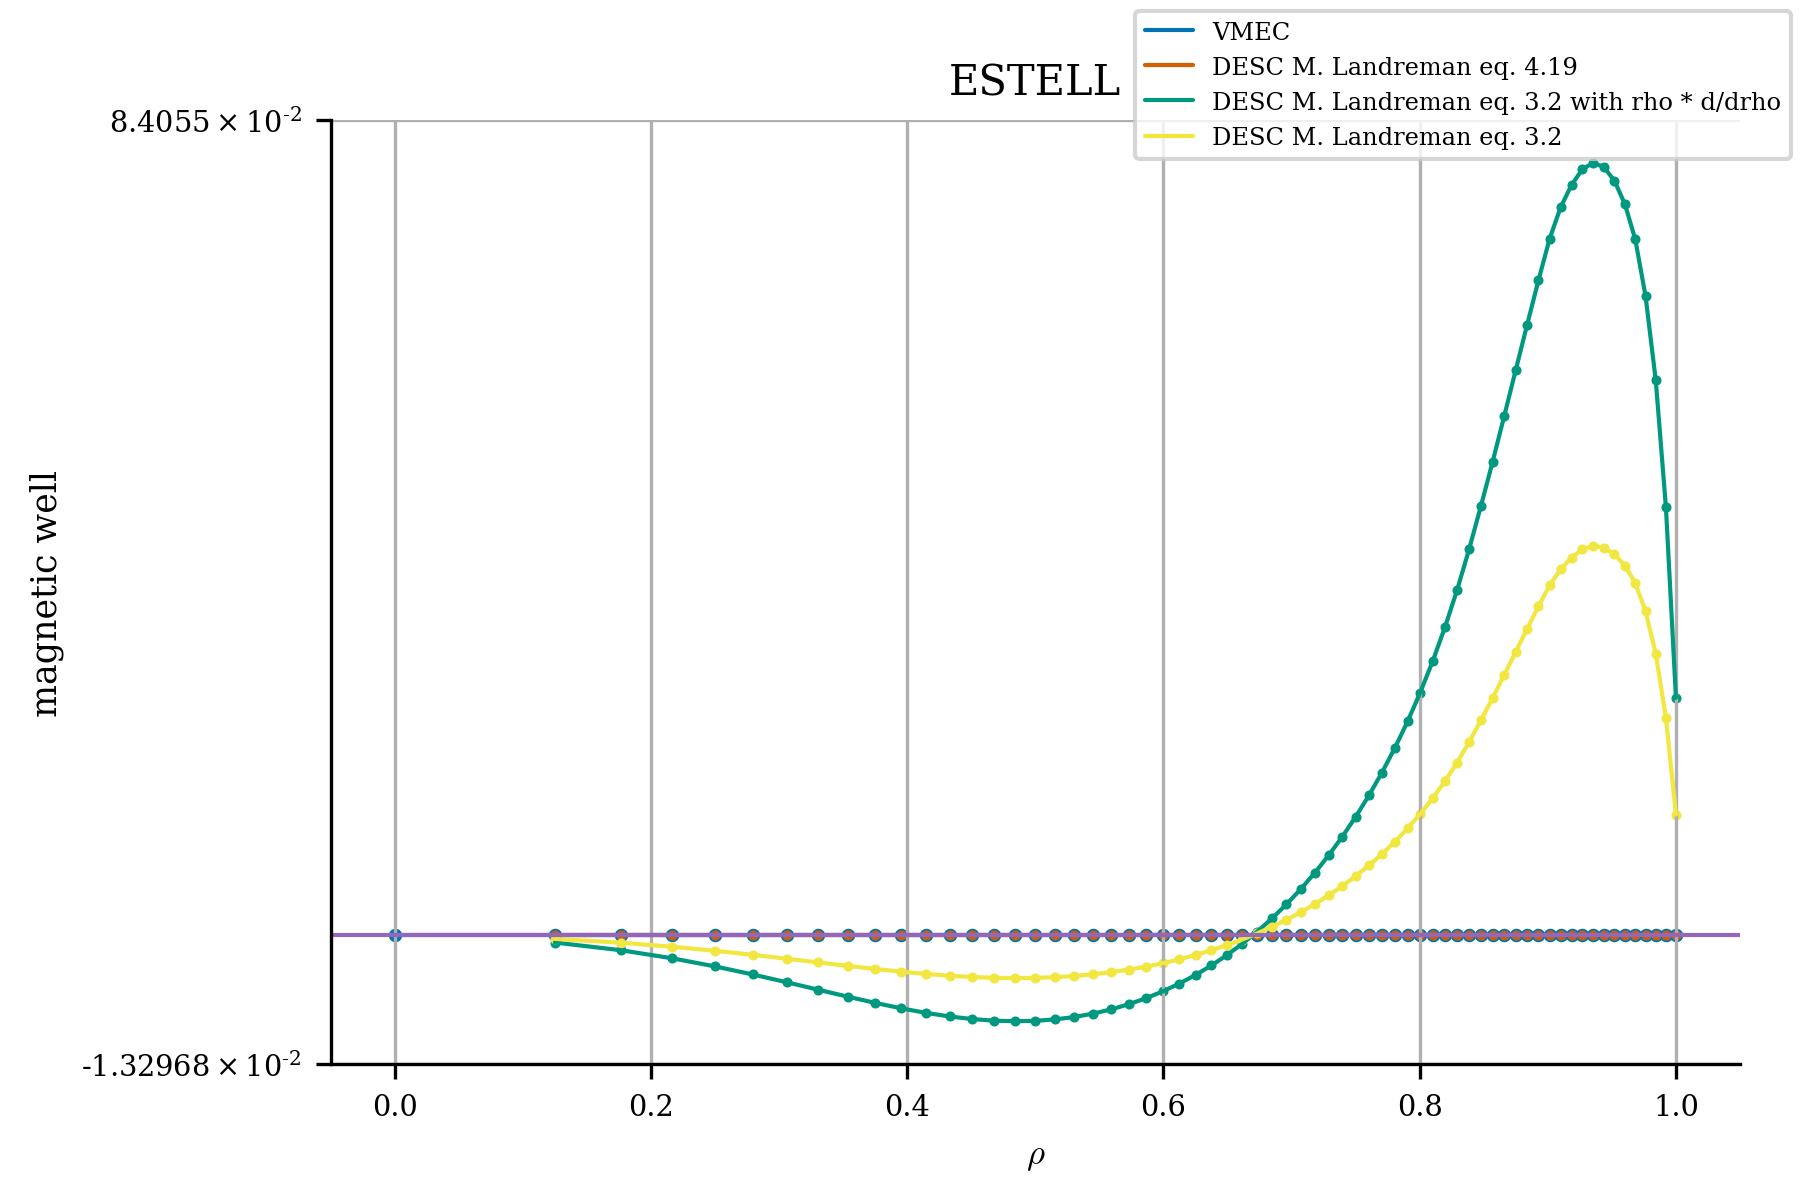

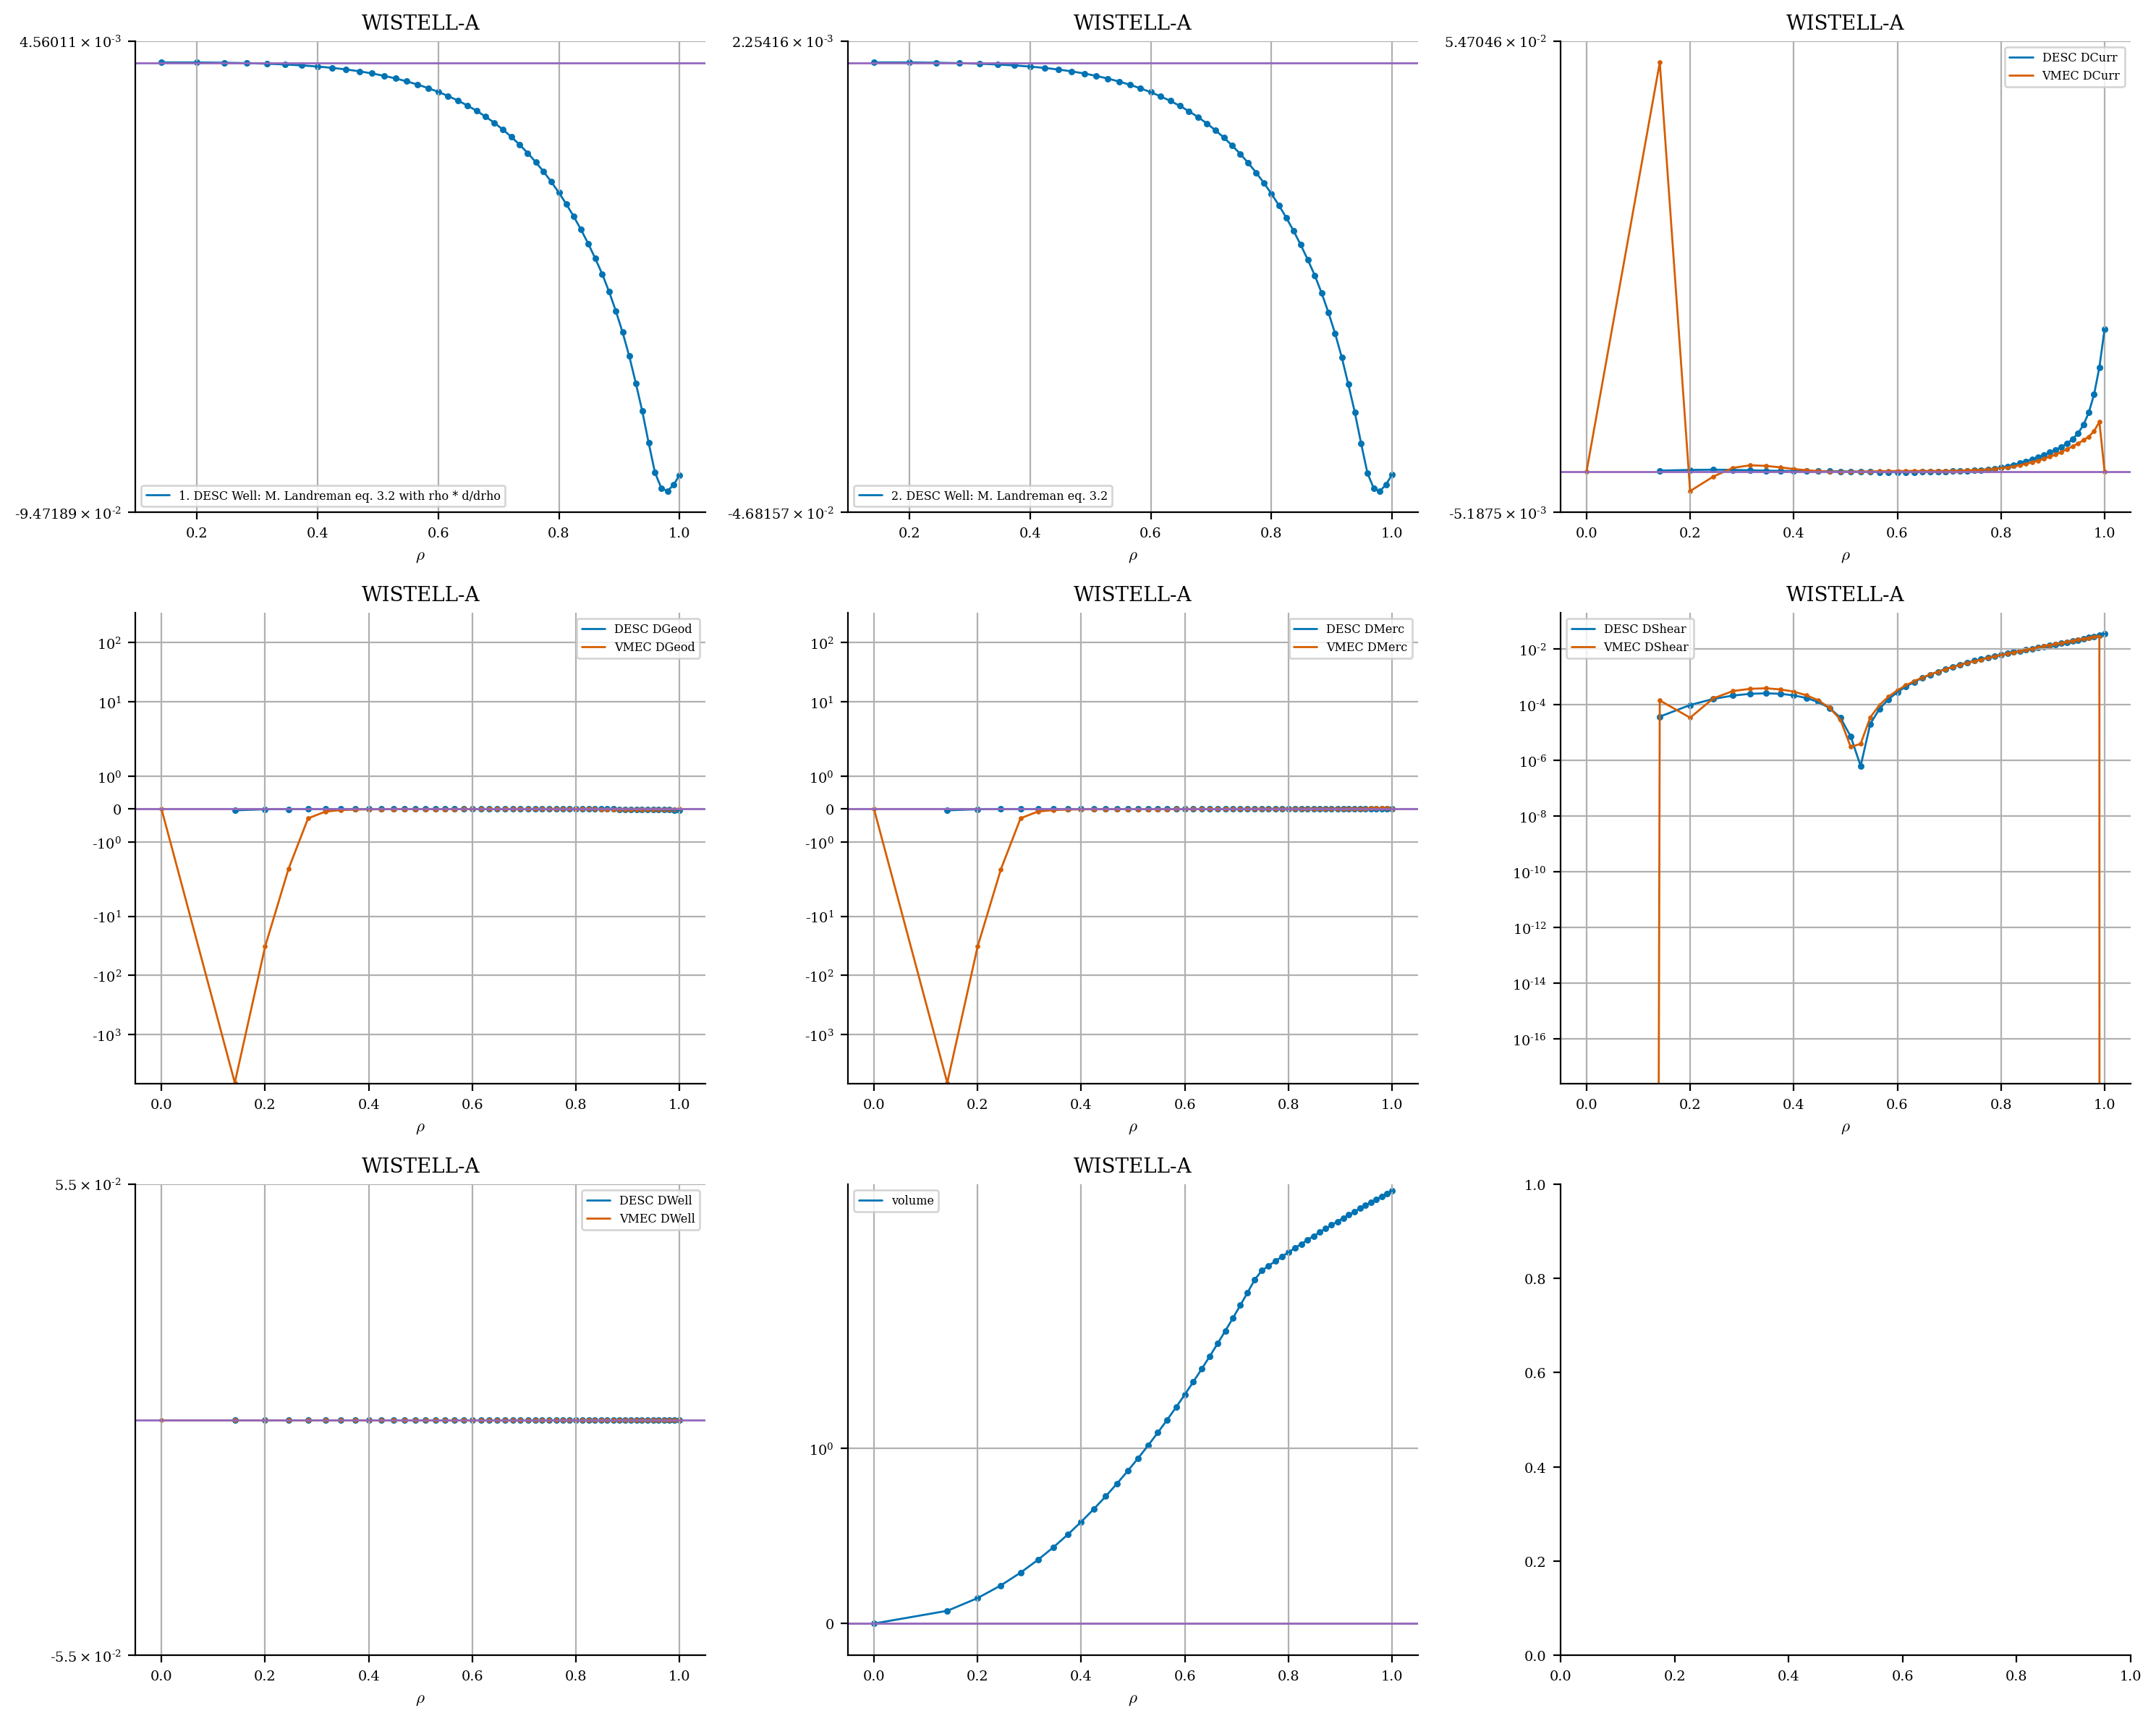

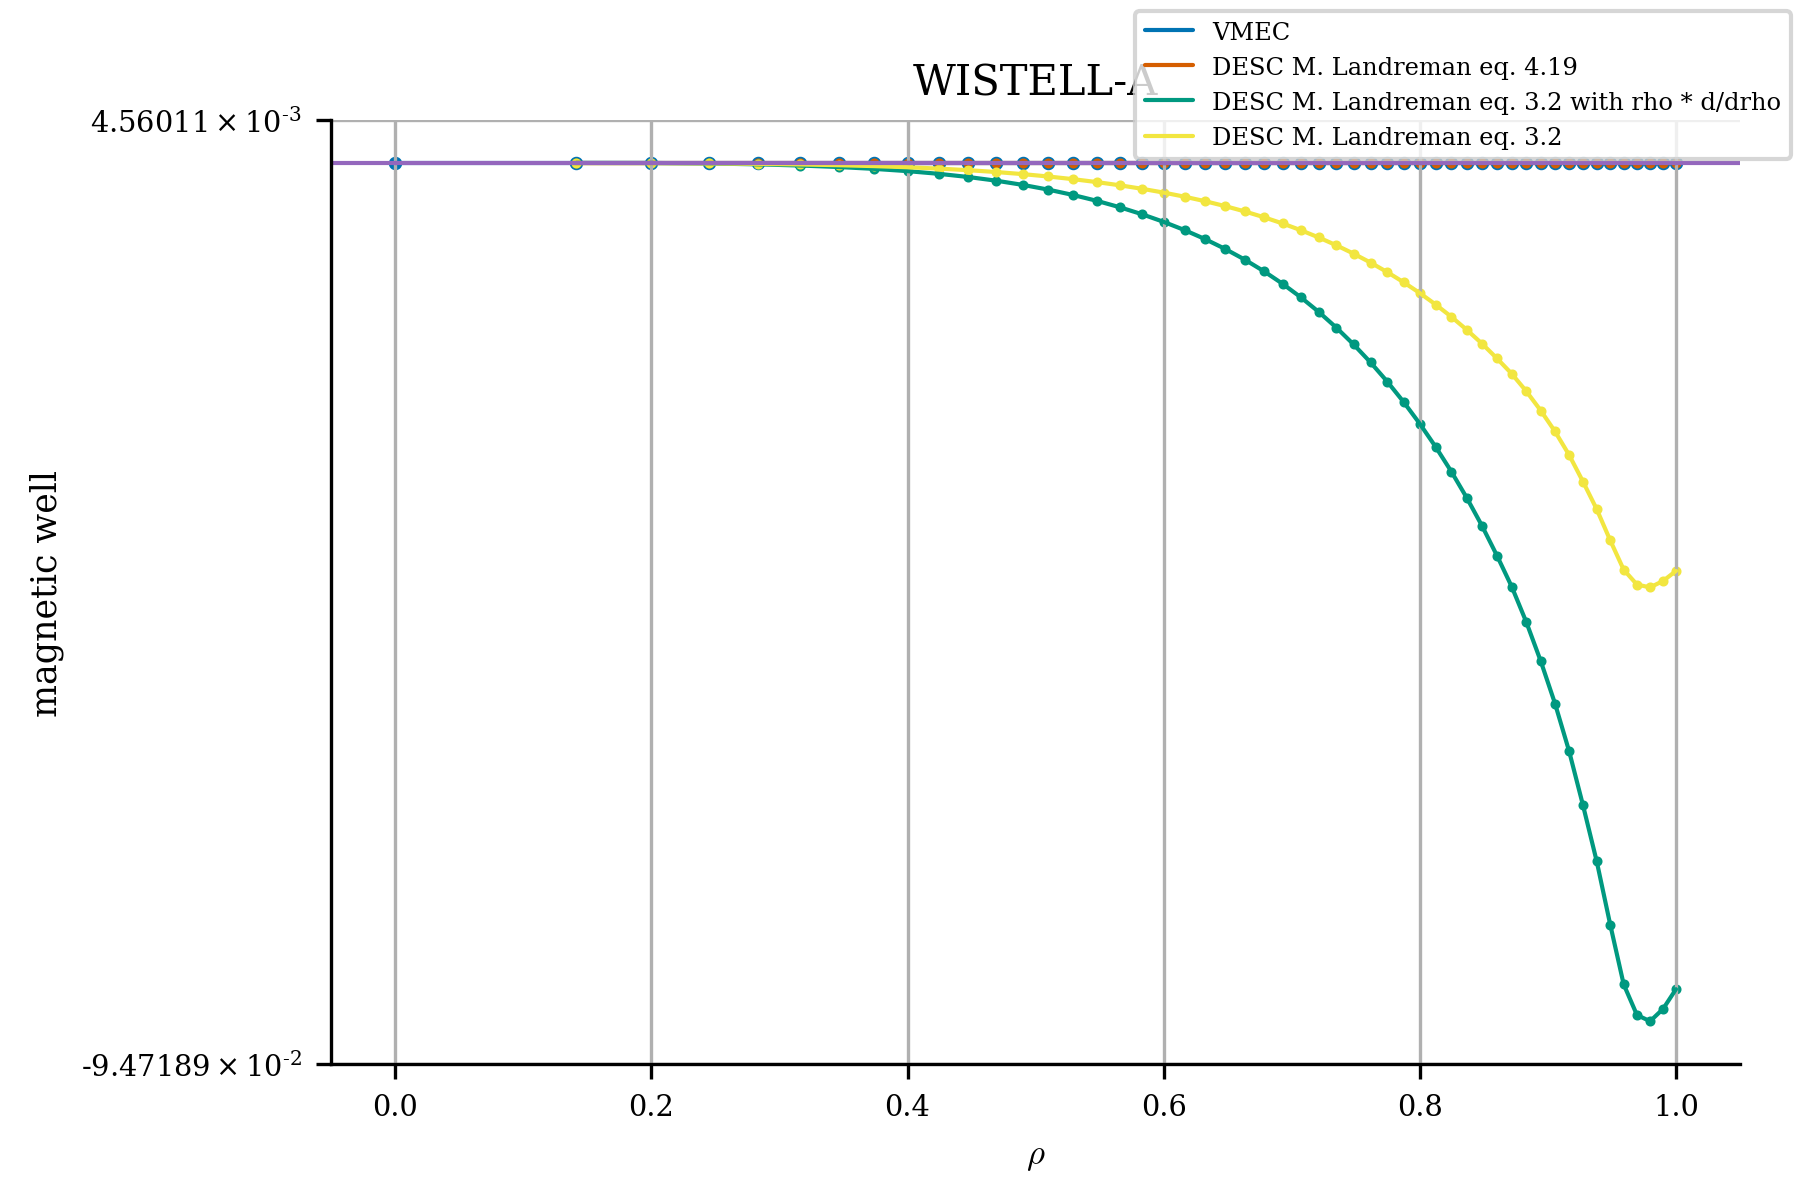

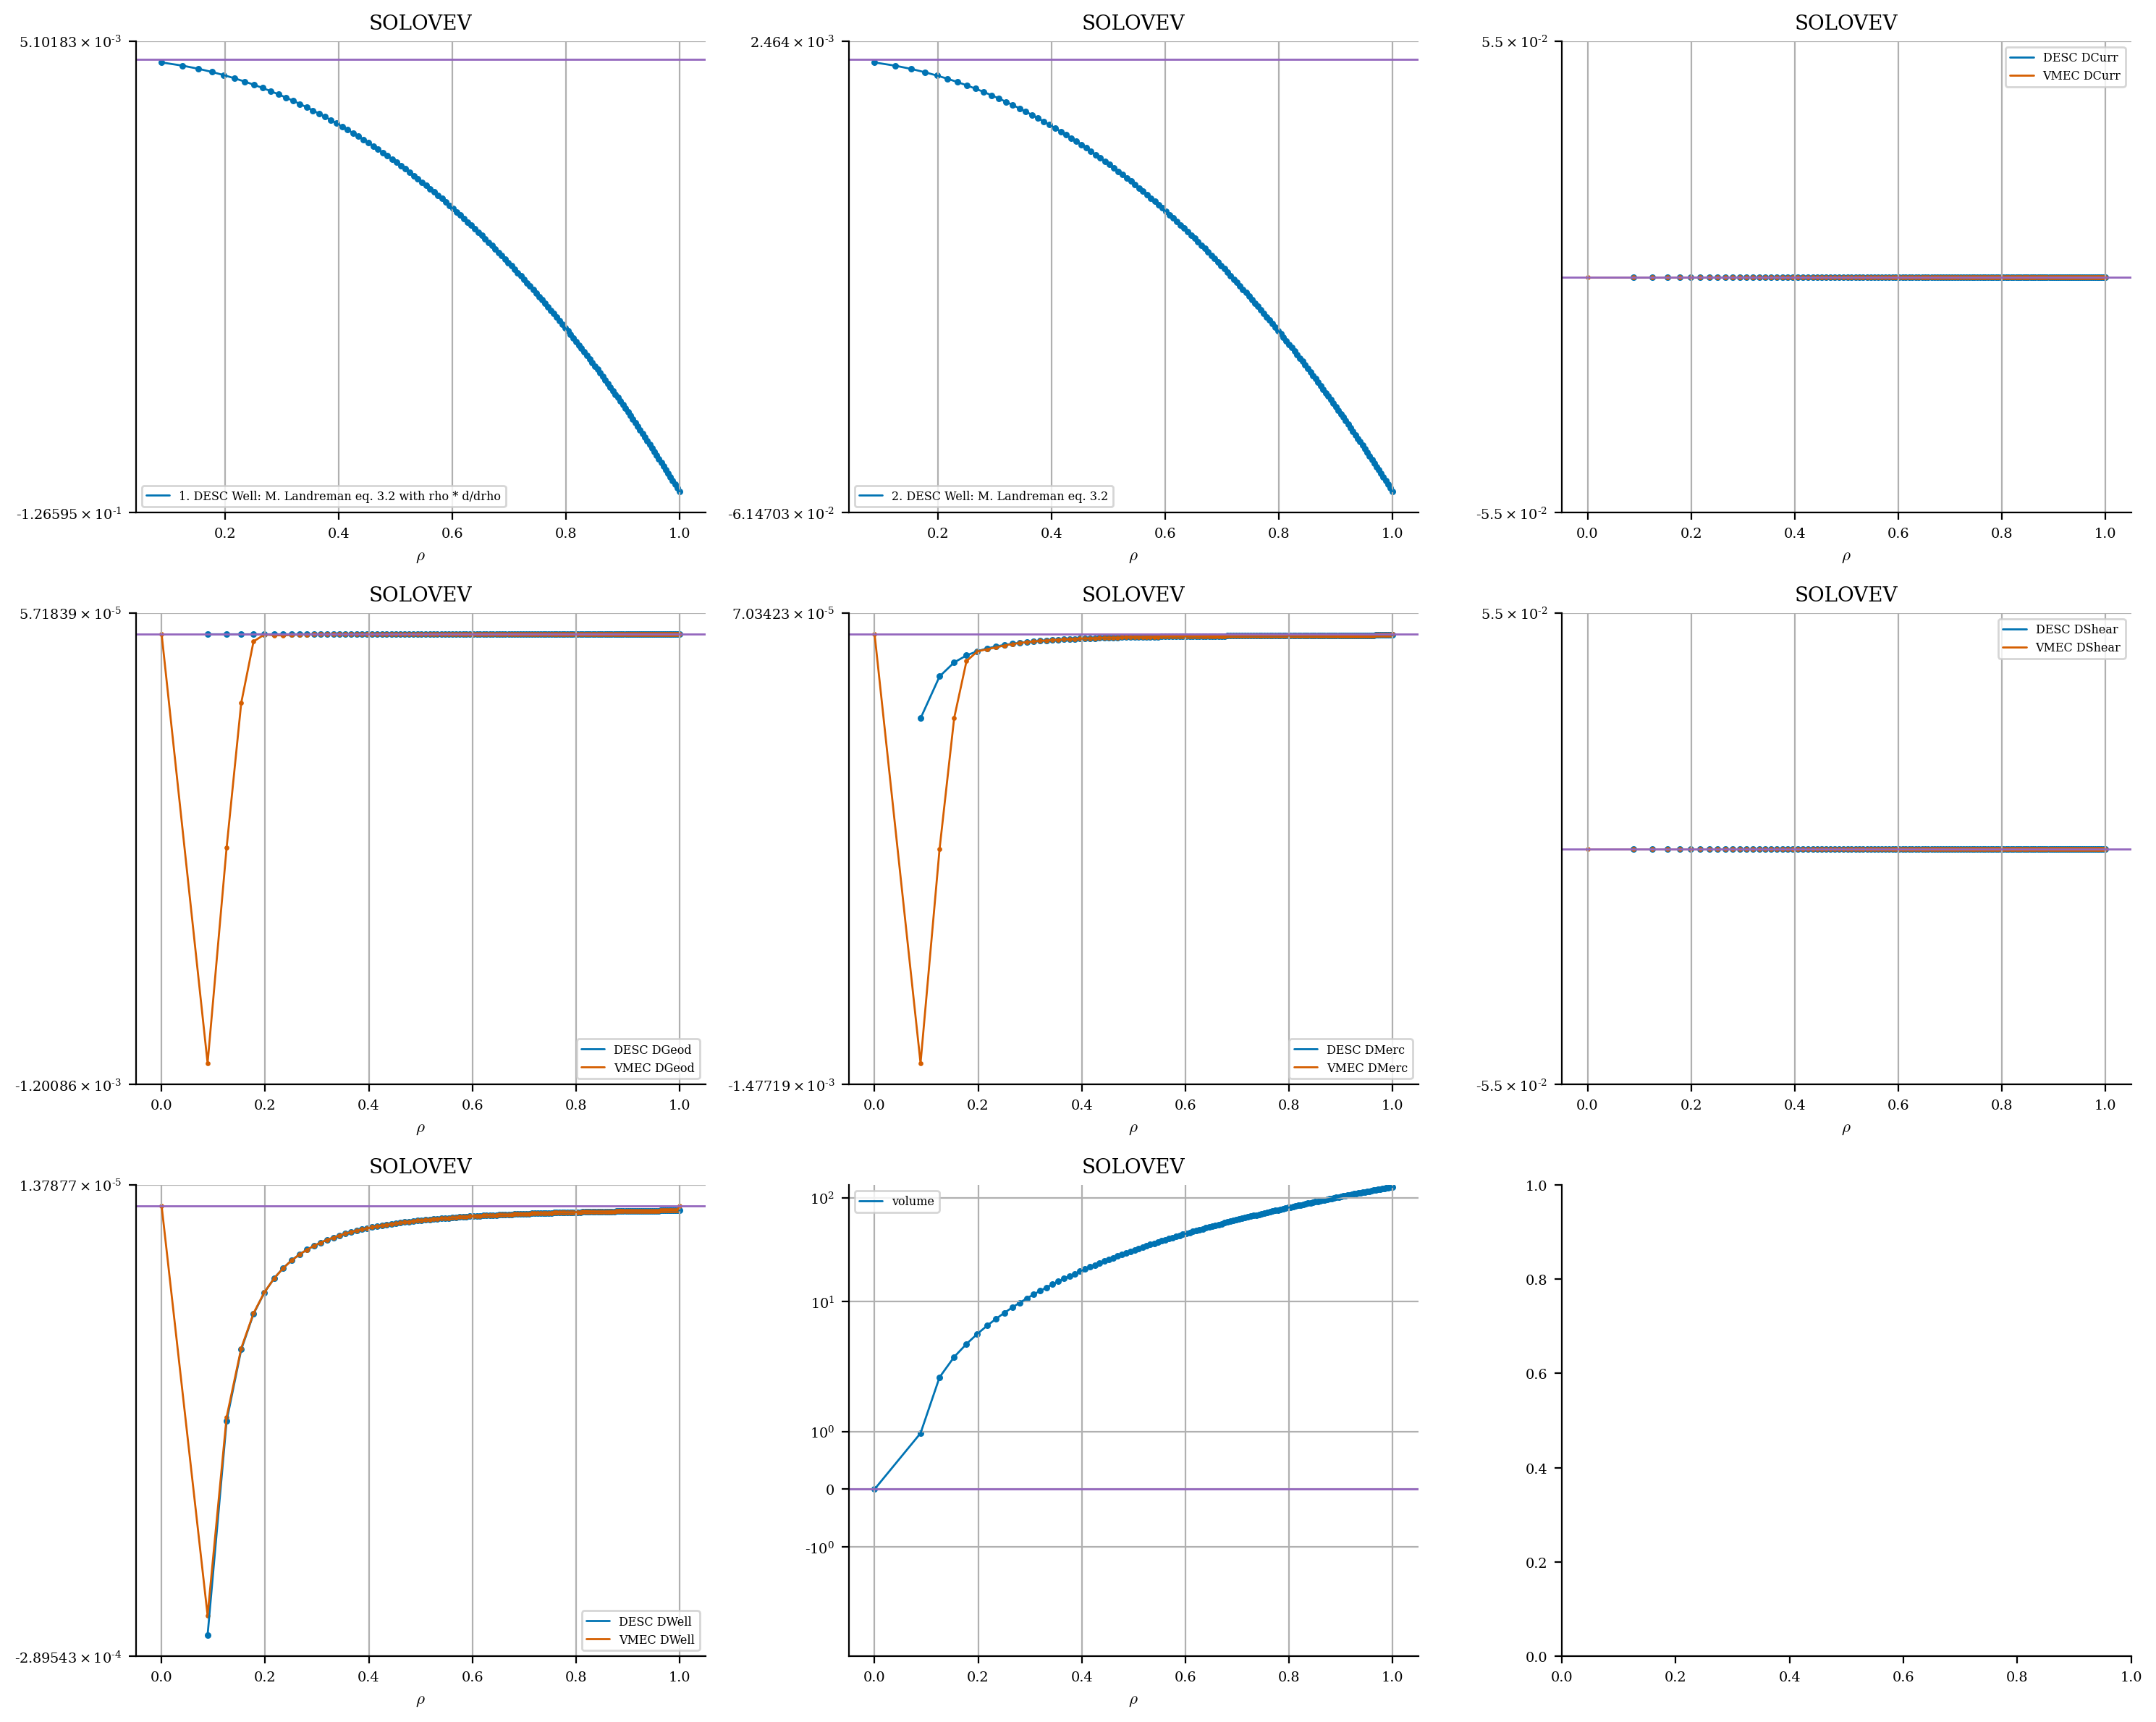

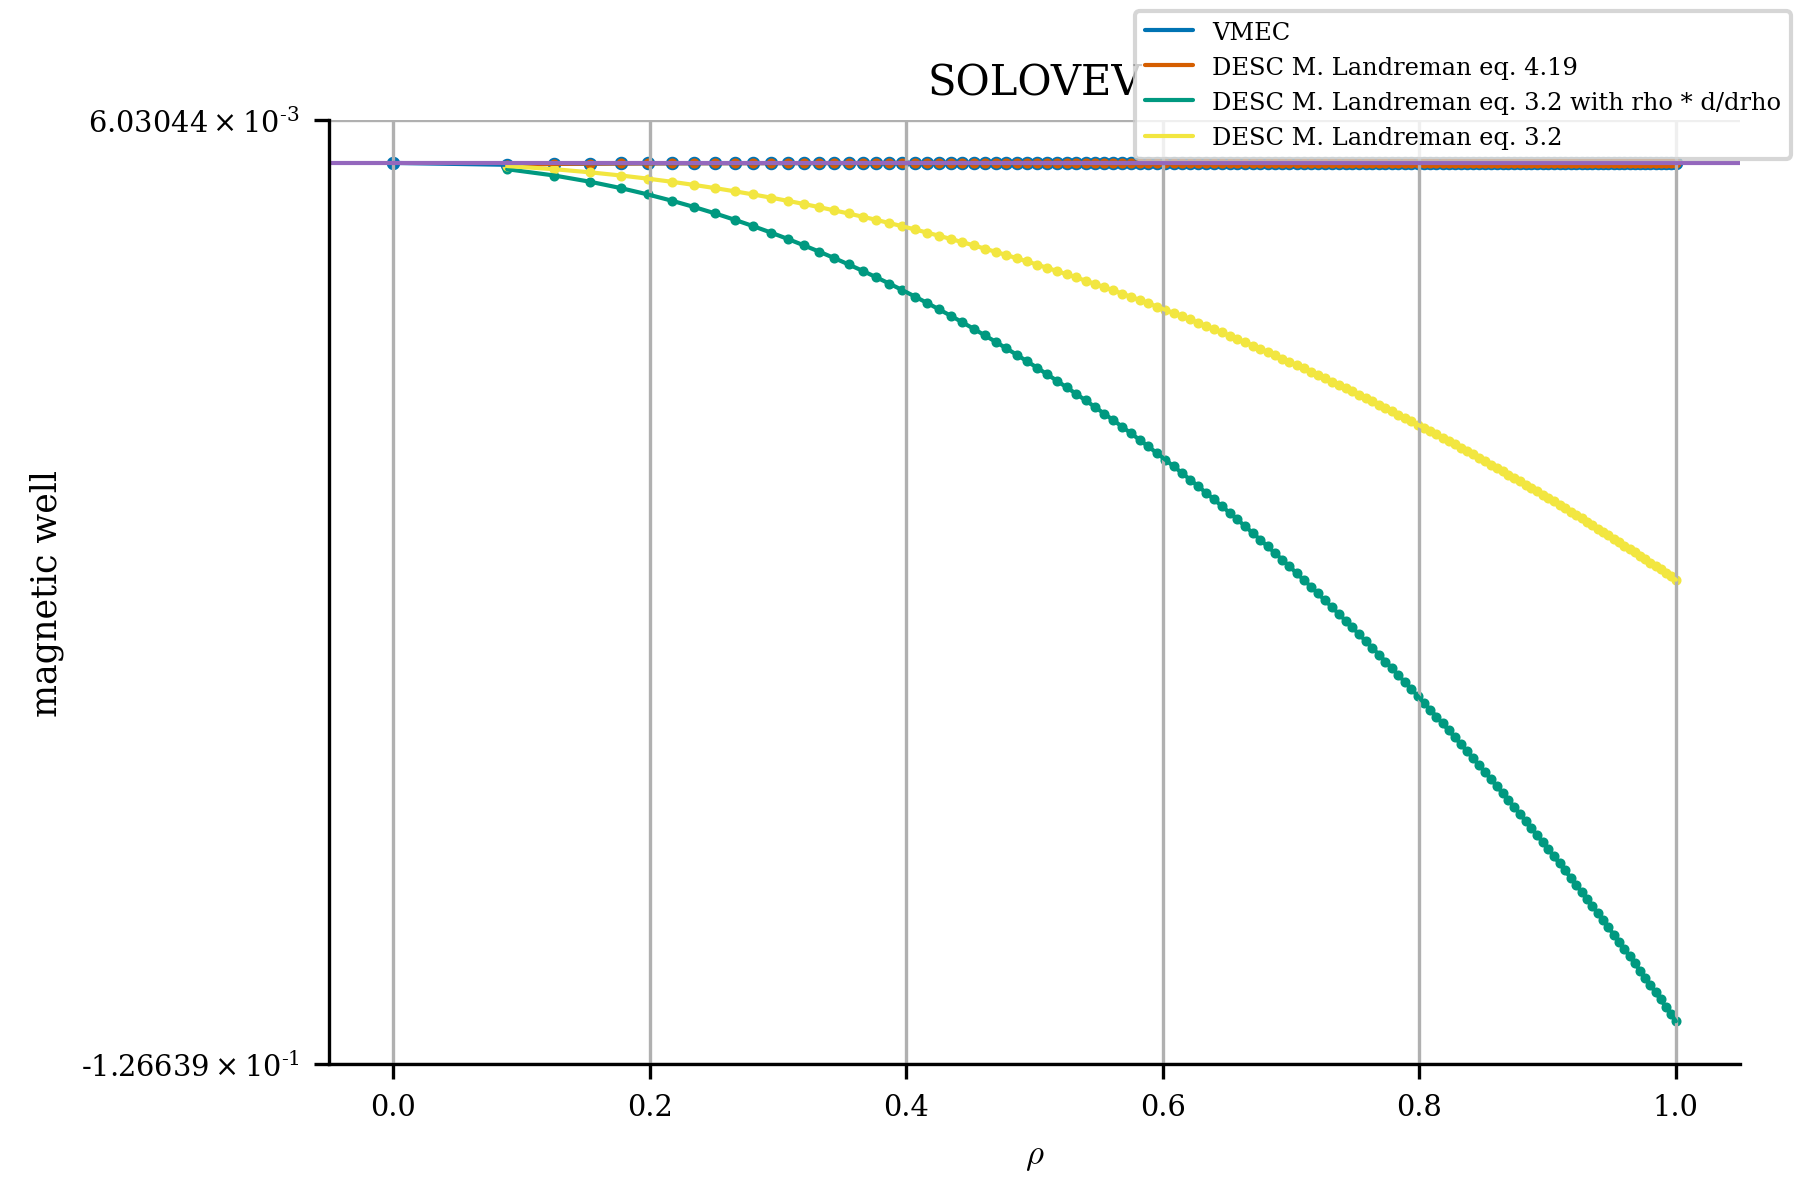

In [10]:
for s in stellarators:
    s.plot()
    s.plot_magnetic_wells()

In [11]:
for s in stellarators:
    s.save()

# Surface element computation problem and solution
In `MagneticWell.compute()`, the volume computation (and others) rely on the quantity d$\theta$ * d$\zeta$. This is obtained from splicing `grid.spacing`. The grid class takes advantage of things like reducing duplicated node weight, stellarator symmetry, and the number of field periods to reduce the amount of computation.

The problem is that, in the grid class's current implementation, the modifications made to `grid.spacing` to take advantage of symmetry and NFP do not preserve the value of d$\theta$ * d$\zeta$. So independently plucking out d$\theta$ * d$\zeta$ from a grid will not give the value its name implies.

Why is this? Because rescaling is done to preserve the full volume, or the weights (d$\rho$ * d$\theta$ * d$\zeta$) so that `grid.spacing.prod(axis=1).sum()` = 4$\pi$<sup>2</sup>, at the expense of changing d$\theta$ * d$\zeta$. Here's a visual:

In [12]:
# For any constant rho surface and NFP=1, grid.spacing is going
# to be an M*N length stack of the row vector (1, 2pi/M, 2pi/N).
g1 = LinearGrid(M=2, N=2, rho=np.array(1))
print(g1.spacing)
print()
# When NFP != 1, the values of drho are increased (decreased) while
# dtheta*dzeta decreases (increases).
# That's why the wrong volume was being computed for the heliotron with NFP > 1.
NFP = np.random.random_sample() * 100
print("NFP:", NFP)
g2 = LinearGrid(M=2, N=2, NFP=NFP, rho=np.array(1))
print(g2.spacing)

# the good thing is that the differential volume drho*dtheta*dzeta is preserved
# since that was the (main?) goal of the rescaling
assert np.allclose(g1.spacing.prod(axis=1), g2.spacing.prod(axis=1))
# and that, because rho=constant forces the drho vector to = 1 (with NFP=1),
# grid.weights is actually the value we expect from dtheta*dzeta (for any NFP).
if g1.num_rho == 1:
    assert np.allclose(g1.spacing.prod(axis=1), g1.spacing[:, 1:].prod(axis=1))
assert np.allclose(g1.spacing.prod(axis=1), g1.weights)  # definition of weights

[[1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]]

NFP: 5.509192958460851
[[1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194 0.4029]
 [1.7662 2.2194

## Solution

On grids which are defined completely by a single rho surface (`grid.num_rho = 1`), the correct volume will be computed $\forall NFP \in \mathbb{R}^{+}$, if we take d$\theta$ * d$\zeta$ to be `grid.weights` instead of `grid.spacing[:, 1:].prod(axis=1)`.

On grids which are defined over a range of rho surfaces (`grid.num_rho != 1`) this will not work because d$\rho$ != 1 on those grids. A general solution follows for computing the correct value for d$\theta$ * d$\zeta$ to other grids $g \in Grid : g.num\_rho \in \mathbb{N}$.
* Let $g1 \in Grid : g1.NFP = 1$ and $g2 \in Grid : g2.NFP \in \mathbb{R}^{+}$. Then given g2, d$\theta$ * d$\zeta$ = `g2.weights / g1.spacing[:, 0]`.
* I don't know how to retrieve g1.d$\rho$ from g2, other than storing it during grid construction.
* Until this can be fixed, any computation which requires differential surface elements (i.e. flux surface averages require the columns from `grid.spacing`) will yield incorrect quantities $\forall g \in Grid : g.num\_rho \in \mathbb{N} \setminus {1}\ and\ g.NFP \in \mathbb{R}^{+} \setminus {1}$.


The last source of error in the volume is the stellarator symmetry boolean. `enforce_symmetry()` again modifies d$\theta$ * d$\zeta$. Visual given below.

The error in computed volume that results from this is much smaller than the NFP error fixed above. The nodes with $\theta$ > $\pi$ are removed and so too are the spacings in the grid that correspond to those nodes. Now because `grid.spacing` is missing these nodes, to preserve the overall volume in ($\rho$, $\theta$, $\zeta$) space (`grid.weights.sum()`), the differential volume d$\rho$ * d$\theta$ * d$\zeta$ of the remaining spaces is increased so that the sum is still 4$\pi$<sup>2</sup>. This makes sense since we do want to increase the weight of the nodes 0 to $\pi$ to double count for the removed nodes. This process has preserving the volume d$\rho$ * d$\theta$ * d$\zeta$ in mind. It's not clear to me if a different scale factor (other than 4$\pi$<sup>2</sup>) would be better to preserve an area element d$\theta$ * d$\zeta$. Might be dependent on $\rho$.

In [13]:
g3 = LinearGrid(M=2, N=2, sym=True, rho=np.array(1))
print(g3.spacing)

[[1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]]
